In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.decomposition import PCA
from umap import UMAP

from neural_analysis.data.synthetic_data import (
    generate_place_cells,
    generate_grid_cells,
    generate_head_direction_cells,
    generate_mixed_population_flexible,
    generate_data,
    generate_swiss_roll,
    generate_s_curve,
    map_to_ring,
    map_to_torus,
)

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)

print("✅ Imports successful!")
print(f"NumPy version: {np.__version__}")
print(f"Random seed: {SEED}")

/mnt/c/Users/mauls/Documents/Code/neural-analysis/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Imports successful!
NumPy version: 2.2.6
Random seed: 42


# Synthetic Dataset Generation for Neural Analysis

This notebook demonstrates comprehensive synthetic dataset generation capabilities including:

1. **Neural Data**: Place cells, grid cells, and head direction cells in 1D, 2D, and 3D environments
2. **Manifold Mapping**: Ring (S¹) for place/HD cells, Torus (T²) for grid cells
3. **Population Decoding**: Tracking trajectories on manifolds via population vectors
4. **Mixed Populations**: Realistic combinations of multiple cell types with configurable noise
5. **sklearn Datasets**: Swiss roll, S-curve, blobs, moons, circles for benchmarking
6. **Embedding Comparison**: Perfect → Noisy → Mixed population embeddings

All visualizations use raster plots with behavioral labels to show the relationship between neural activity and behavior.

## Part 1: Neural Data - Place Cells in Multiple Dimensions

Place cells fire when the animal is in specific locations. Let's generate place cell activity in 1D, 2D, and 3D environments.

### 1D Place Cells (Linear Track)

Place cells on a linear track with localized firing fields.

/mnt/c/Users/mauls/Documents/Code/neural-analysis/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


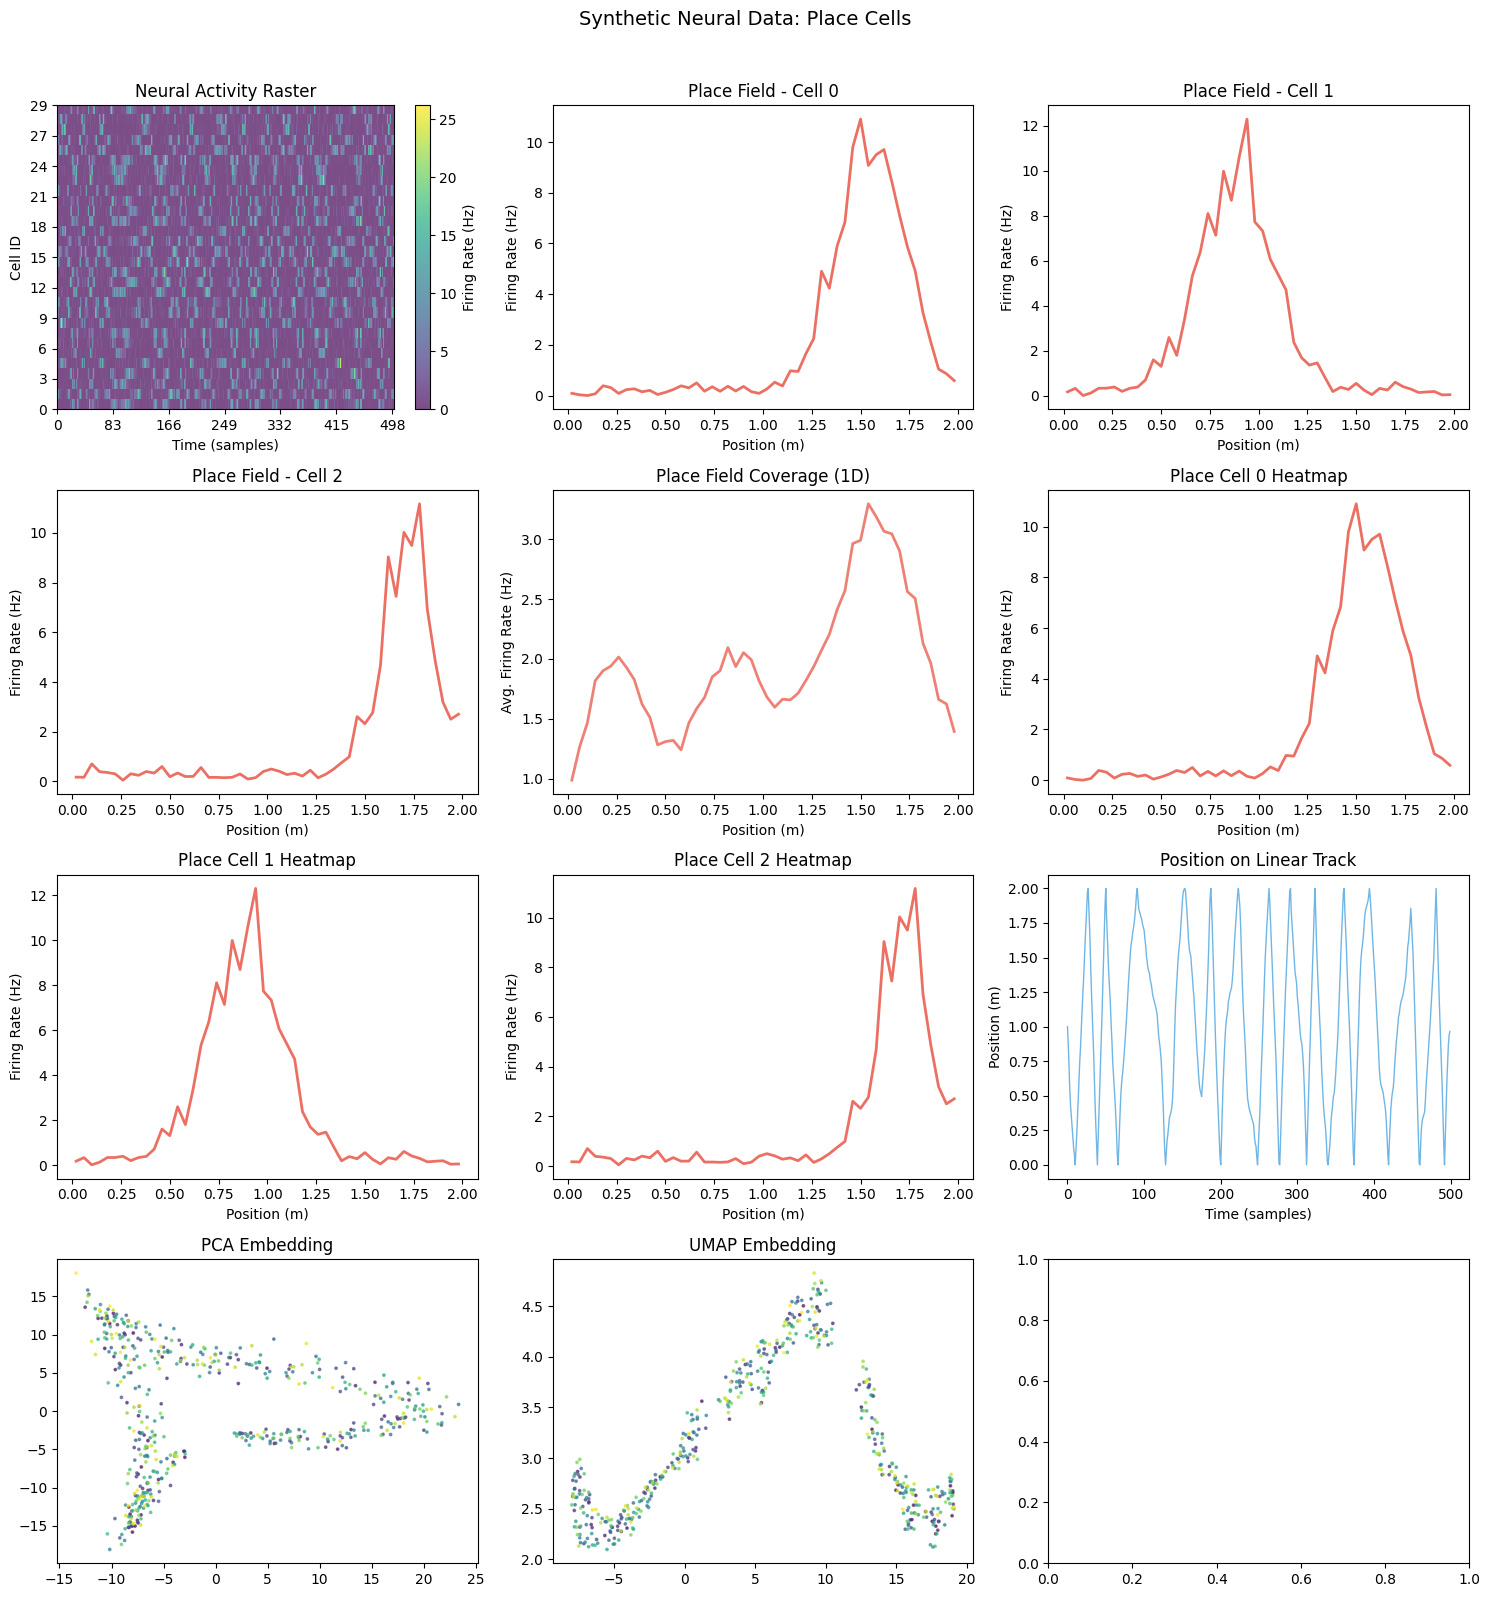

In [5]:
# Generate 1D place cells
activity_1d, meta_1d = generate_place_cells(
    n_cells=30,
    n_samples=500,
    arena_size=2.0,  # 2 meter linear track
    field_size=0.15,
    peak_rate=10.0,
    noise_level=0.05,
    seed=SEED,
)

### 2D Place Cells (Open Field)

Place cells in a 2D arena with Gaussian firing fields tiling the space.

/mnt/c/Users/mauls/Documents/Code/neural-analysis/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


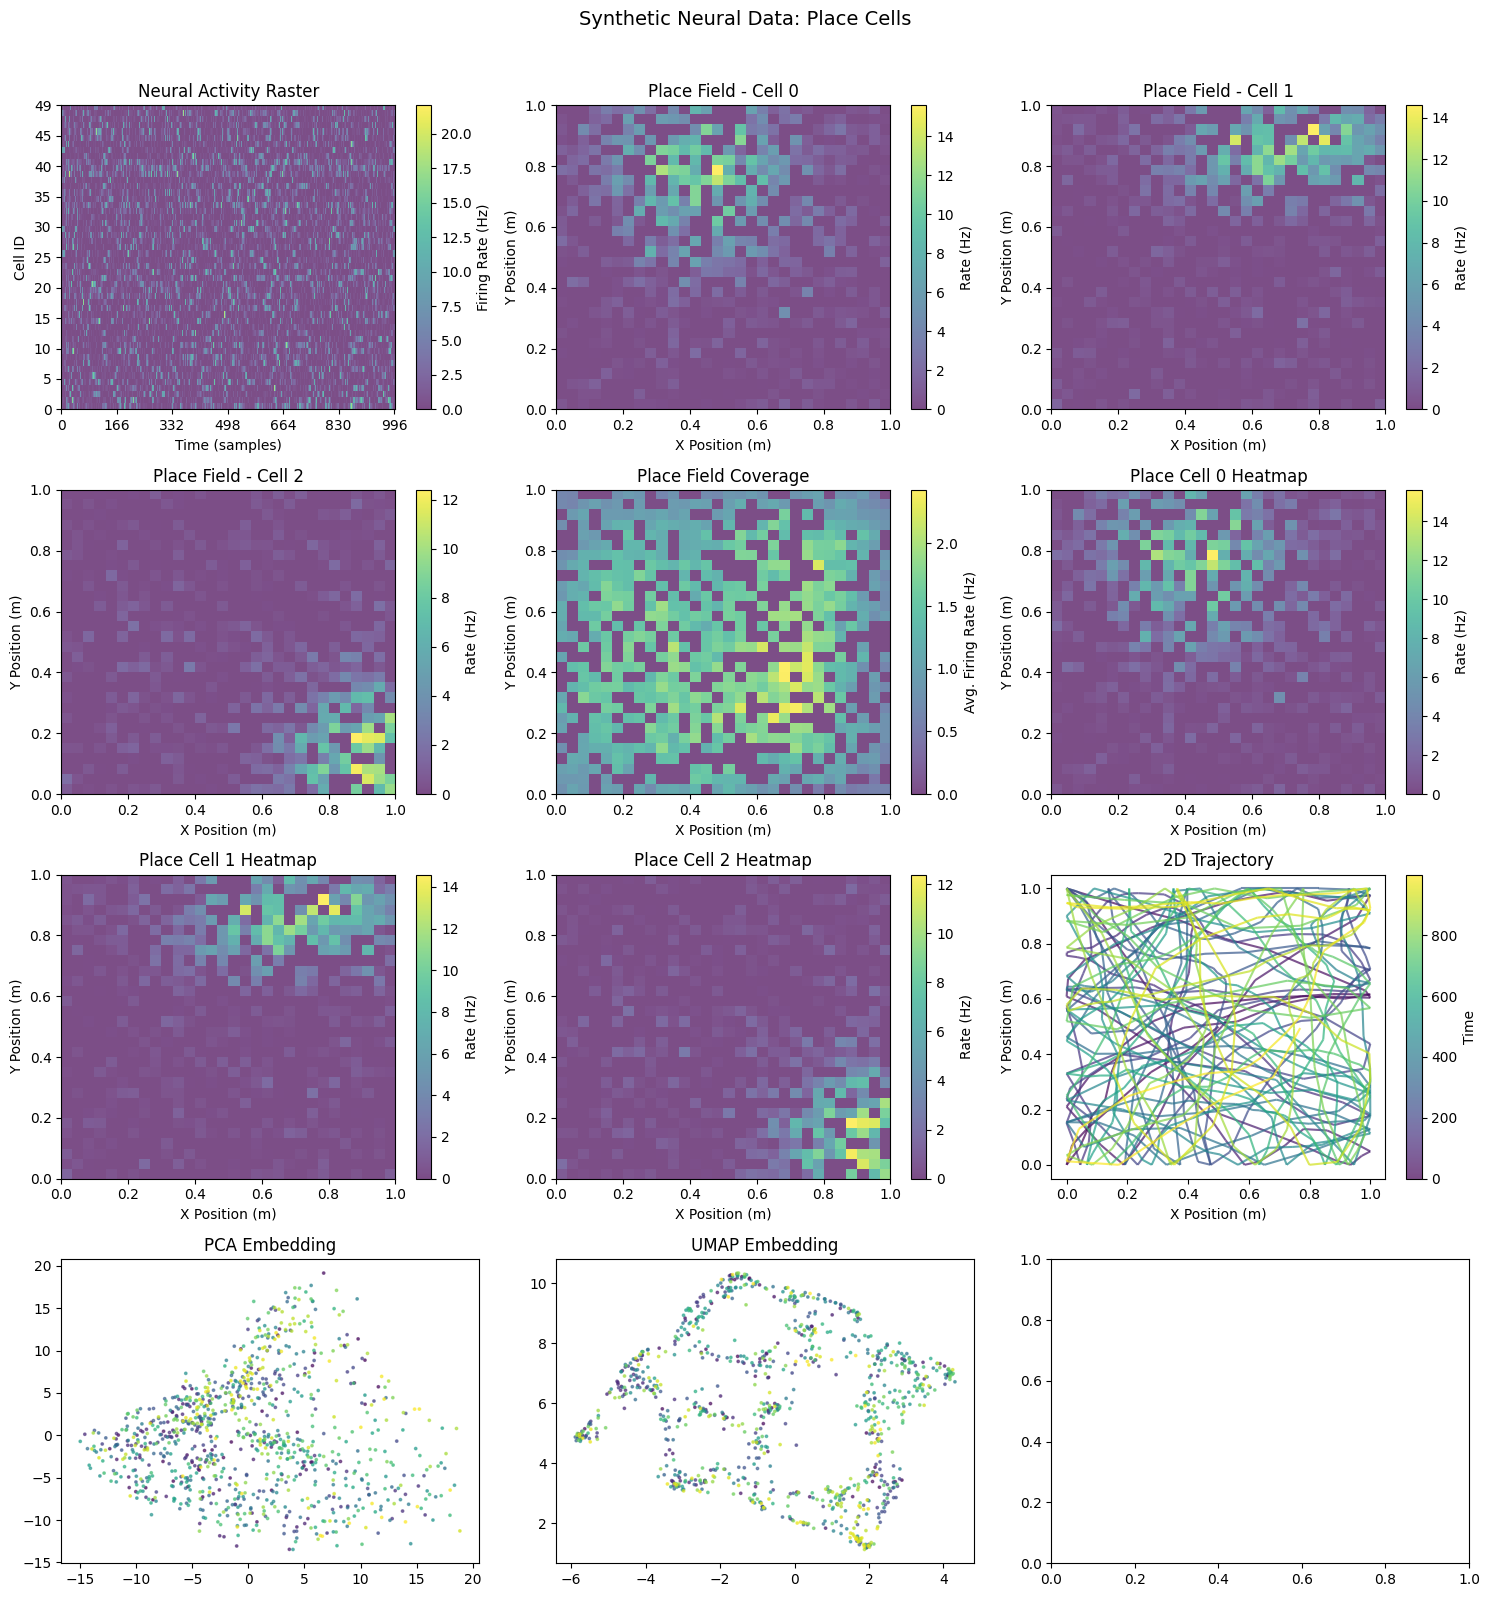

In [3]:
# Generate 2D place cells
activity_2d, meta_2d = generate_place_cells(
    n_cells=50,
    n_samples=1000,
    arena_size=(1.0, 1.0),  # 1m x 1m arena
    field_size=0.15,
    peak_rate=10.0,
    noise_level=0.05,
    seed=SEED,
)

### 3D Place Cells (Volumetric Space)

Place cells in a 3D volumetric environment.

/mnt/c/Users/mauls/Documents/Code/neural-analysis/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


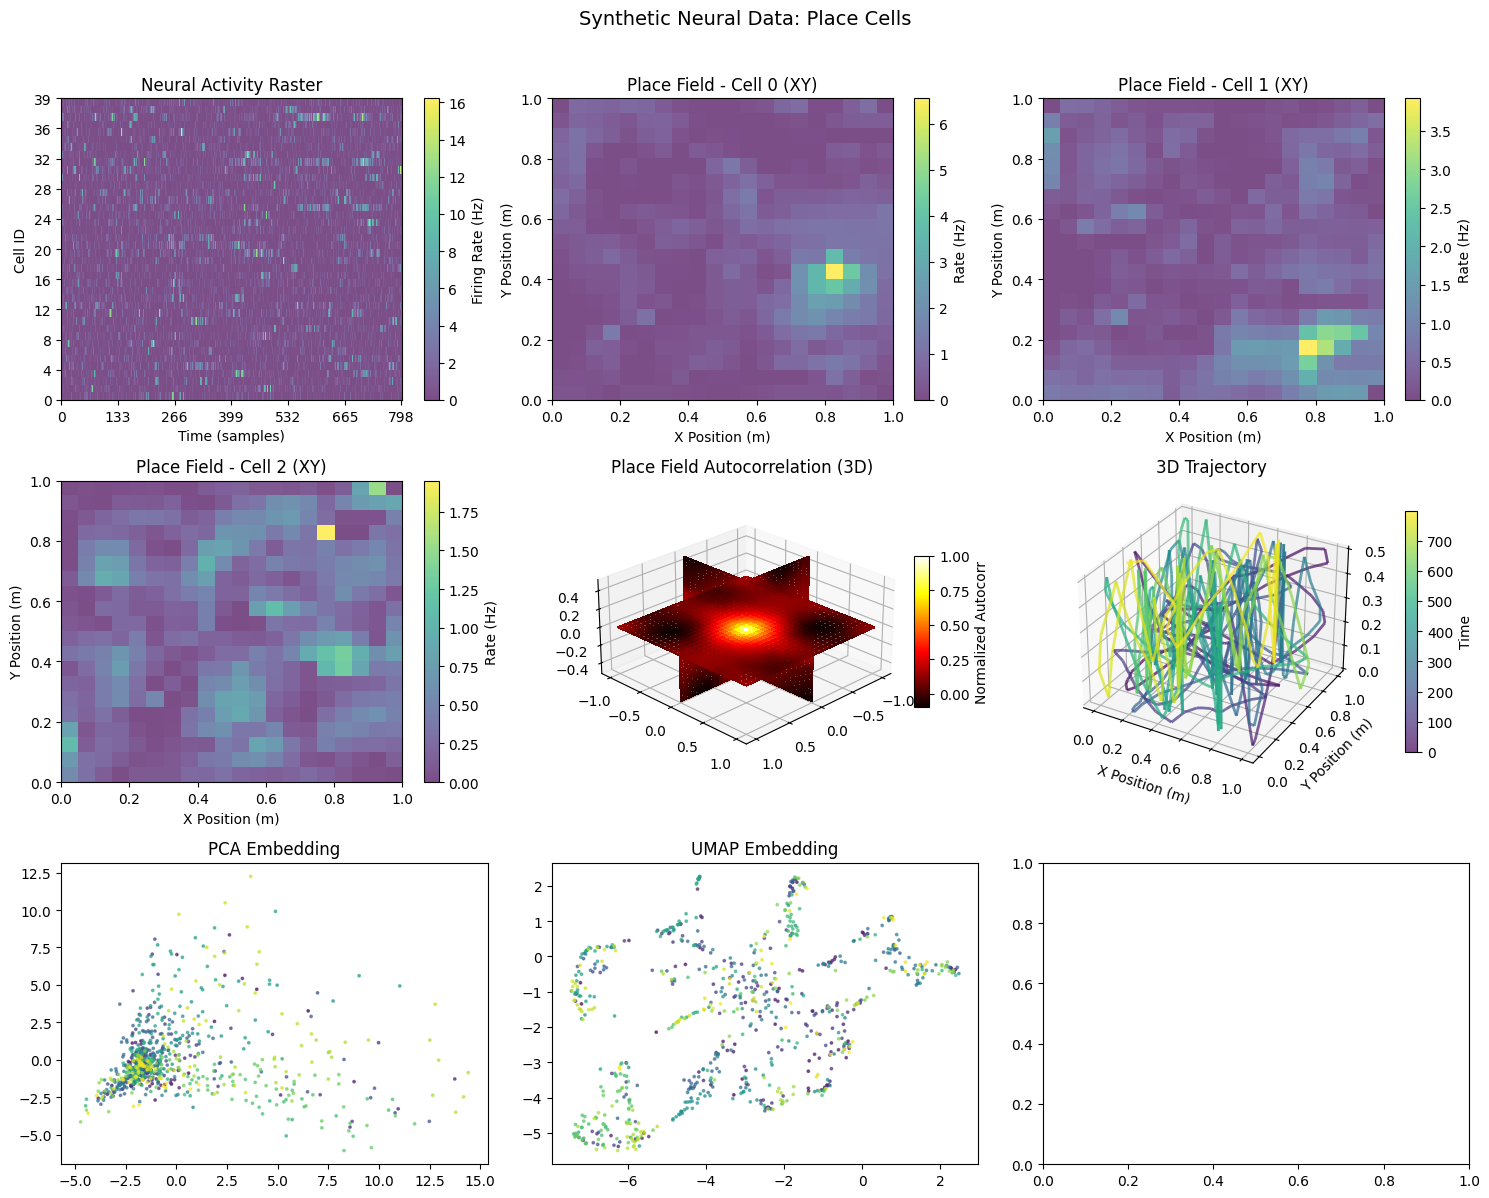

In [4]:
# Generate 3D place cells
activity_3d, meta_3d = generate_place_cells(
    n_cells=40,
    n_samples=800,
    arena_size=(1.0, 1.0, 0.5),  # 1m x 1m x 0.5m arena
    field_size=0.12,
    peak_rate=10.0,
    noise_level=0.05,
    seed=SEED,
)


### 3D Place Field Coverage Visualization

Visualize how place cells tile the 3D volumetric space with their firing fields.

/tmp/ipykernel_1384569/1341813069.py:69: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax2.scatter(
/tmp/ipykernel_1384569/1341813069.py:96: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax3.scatter(
/tmp/ipykernel_1384569/1341813069.py:123: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax4.scatter(
/tmp/ipykernel_1384569/1341813069.py:140: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


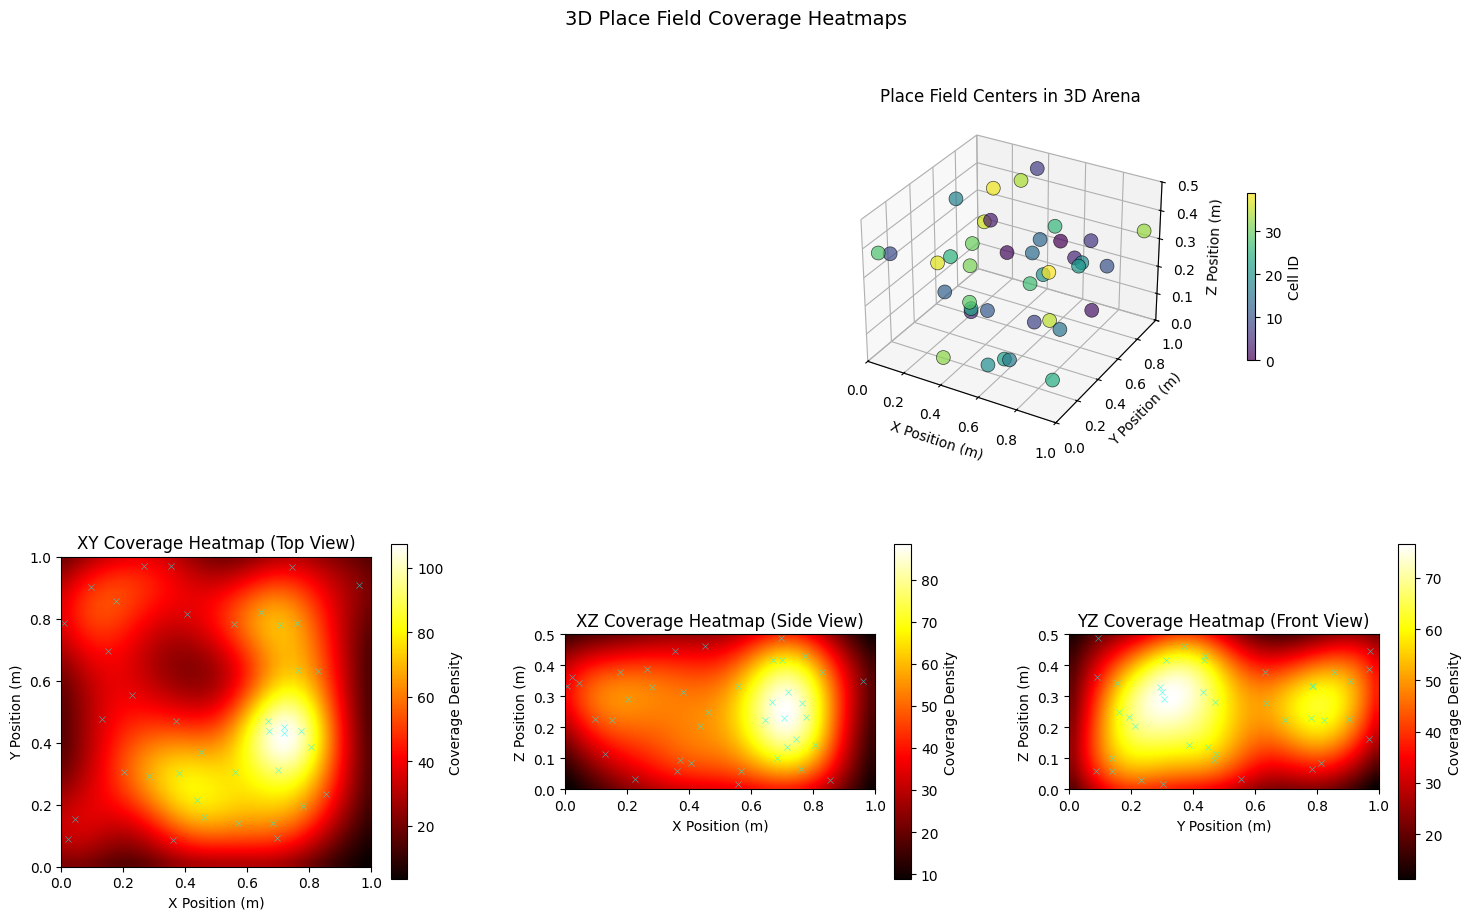

3D Place Field Coverage:
  Number of cells: 40
  Arena size: 1.00m × 1.00m × 0.50m
  Field size (radius): 0.120m
  Volume per field: 0.0072 m³
  Total arena volume: 0.5000 m³
  Mean coverage density: 1.54
  Max coverage density: 4.65
  Coverage uniformity (std/mean): 0.54


In [5]:
# Visualize 3D place field coverage as heatmap
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter

# Extract place field centers from metadata
place_field_centers = meta_3d["field_centers"]
arena_size_3d = meta_3d["arena_size"]
field_size_3d = meta_3d["field_size"]

# Create a 3D grid to compute coverage density
n_bins = 30
x_edges = np.linspace(0, arena_size_3d[0], n_bins + 1)
y_edges = np.linspace(0, arena_size_3d[1], n_bins + 1)
z_edges = np.linspace(0, arena_size_3d[2], n_bins + 1)

# Compute coverage by summing Gaussian contributions from each place field
x_centers = (x_edges[:-1] + x_edges[1:]) / 2
y_centers = (y_edges[:-1] + y_edges[1:]) / 2
z_centers = (z_edges[:-1] + z_edges[1:]) / 2

X, Y, Z = np.meshgrid(x_centers, y_centers, z_centers, indexing="ij")
coverage_3d = np.zeros_like(X)

# Sum Gaussian contributions from each place field
for center in place_field_centers:
    distances = np.sqrt(
        (X - center[0]) ** 2 + (Y - center[1]) ** 2 + (Z - center[2]) ** 2
    )
    coverage_3d += np.exp(-(distances**2) / (2 * field_size_3d**2))

# Create figure with subplots
fig = plt.figure(figsize=(18, 10))
gs = GridSpec(2, 3, hspace=0.3, wspace=0.3)

# 3D scatter plot of place field centers
ax1 = fig.add_subplot(gs[0, :], projection="3d")
scatter = ax1.scatter(
    place_field_centers[:, 0],
    place_field_centers[:, 1],
    place_field_centers[:, 2],
    c=np.arange(len(place_field_centers)),
    cmap="viridis",
    s=100,
    alpha=0.7,
    edgecolors="k",
    linewidth=0.5,
)
ax1.set_xlabel("X Position (m)")
ax1.set_ylabel("Y Position (m)")
ax1.set_zlabel("Z Position (m)")
ax1.set_title("Place Field Centers in 3D Arena")
ax1.set_xlim([0, arena_size_3d[0]])
ax1.set_ylim([0, arena_size_3d[1]])
ax1.set_zlim([0, arena_size_3d[2]])
plt.colorbar(scatter, ax=ax1, label="Cell ID", shrink=0.5)

# 2D heatmap projections showing coverage density
# XY projection (integrate over Z)
ax2 = fig.add_subplot(gs[1, 0])
coverage_xy = np.sum(coverage_3d, axis=2)
im = ax2.imshow(
    coverage_xy.T,
    origin="lower",
    cmap="hot",
    aspect="auto",
    extent=[0, arena_size_3d[0], 0, arena_size_3d[1]],
    interpolation="bilinear",
)
ax2.scatter(
    place_field_centers[:, 0],
    place_field_centers[:, 1],
    c="cyan",
    s=20,
    alpha=0.6,
    edgecolors="white",
    linewidth=0.5,
    marker="x",
)
ax2.set_xlabel("X Position (m)")
ax2.set_ylabel("Y Position (m)")
ax2.set_title("XY Coverage Heatmap (Top View)")
ax2.set_aspect("equal")
plt.colorbar(im, ax=ax2, label="Coverage Density")

# XZ projection (integrate over Y)
ax3 = fig.add_subplot(gs[1, 1])
coverage_xz = np.sum(coverage_3d, axis=1)
im = ax3.imshow(
    coverage_xz.T,
    origin="lower",
    cmap="hot",
    aspect="auto",
    extent=[0, arena_size_3d[0], 0, arena_size_3d[2]],
    interpolation="bilinear",
)
ax3.scatter(
    place_field_centers[:, 0],
    place_field_centers[:, 2],
    c="cyan",
    s=20,
    alpha=0.6,
    edgecolors="white",
    linewidth=0.5,
    marker="x",
)
ax3.set_xlabel("X Position (m)")
ax3.set_ylabel("Z Position (m)")
ax3.set_title("XZ Coverage Heatmap (Side View)")
ax3.set_aspect("equal")
plt.colorbar(im, ax=ax3, label="Coverage Density")

# YZ projection (integrate over X)
ax4 = fig.add_subplot(gs[1, 2])
coverage_yz = np.sum(coverage_3d, axis=0)
im = ax4.imshow(
    coverage_yz.T,
    origin="lower",
    cmap="hot",
    aspect="auto",
    extent=[0, arena_size_3d[1], 0, arena_size_3d[2]],
    interpolation="bilinear",
)
ax4.scatter(
    place_field_centers[:, 1],
    place_field_centers[:, 2],
    c="cyan",
    s=20,
    alpha=0.6,
    edgecolors="white",
    linewidth=0.5,
    marker="x",
)
ax4.set_xlabel("Y Position (m)")
ax4.set_ylabel("Z Position (m)")
ax4.set_title("YZ Coverage Heatmap (Front View)")
ax4.set_aspect("equal")
plt.colorbar(im, ax=ax4, label="Coverage Density")

plt.suptitle("3D Place Field Coverage Heatmaps", fontsize=14, y=0.98)
plt.tight_layout()
plt.show()

print(f"3D Place Field Coverage:")
print(f"  Number of cells: {len(place_field_centers)}")
print(
    f"  Arena size: {arena_size_3d[0]:.2f}m × {arena_size_3d[1]:.2f}m × {arena_size_3d[2]:.2f}m"
)
print(f"  Field size (radius): {field_size_3d:.3f}m")
print(f"  Volume per field: {(4 / 3) * np.pi * field_size_3d**3:.4f} m³")
print(
    f"  Total arena volume: {arena_size_3d[0] * arena_size_3d[1] * arena_size_3d[2]:.4f} m³"
)
print(f"  Mean coverage density: {coverage_3d.mean():.2f}")
print(f"  Max coverage density: {coverage_3d.max():.2f}")
print(f"  Coverage uniformity (std/mean): {coverage_3d.std() / coverage_3d.mean():.2f}")

## Part 2: Grid Cells in Multiple Dimensions

Grid cells fire at multiple locations arranged in regular periodic patterns.

### 1D Grid Cells

Periodic firing pattern along a linear track.

/mnt/c/Users/mauls/Documents/Code/neural-analysis/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


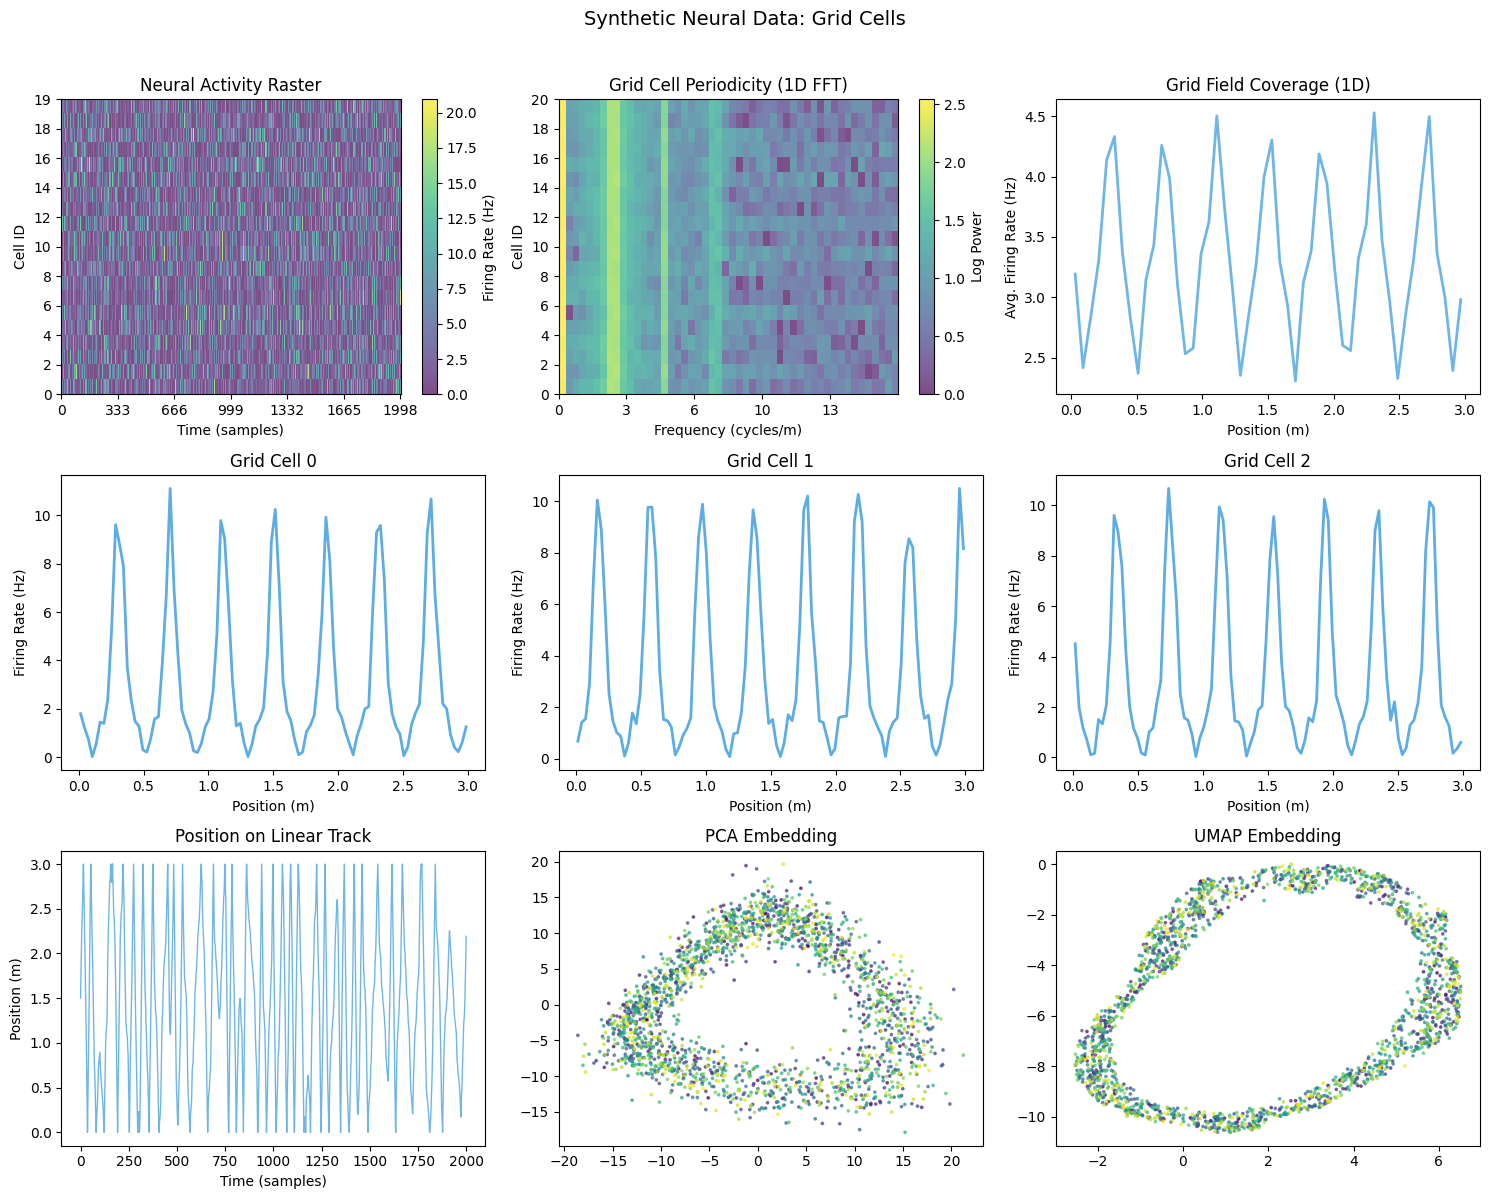

In [7]:
# Generate 1D grid cells
grid_1d, grid_meta_1d = generate_grid_cells(
    n_cells=20,
    n_samples=2000,
    arena_size=3.0,
    grid_spacing=0.4,
    peak_rate=10.0,
    noise_level=0.05,
    seed=SEED,
)

### 2D Grid Cells - Hexagonal Pattern

The classic hexagonal grid pattern observed in entorhinal cortex.

In [21]:
# Reload modules to get latest changes
import importlib
import neural_analysis.data.synthetic_data
import neural_analysis.plotting.synthetic_plots

importlib.reload(neural_analysis.data.synthetic_data)
importlib.reload(neural_analysis.plotting.synthetic_plots)

print("✅ Modules reloaded - now testing with fixed subplot order and noise")

✅ Modules reloaded - now testing with fixed subplot order and noise


In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.decomposition import PCA
from umap import UMAP

from neural_analysis.data.synthetic_data import (
    generate_place_cells,
    generate_grid_cells,
    generate_head_direction_cells,
    generate_mixed_population_flexible,
    generate_data,
    generate_swiss_roll,
    generate_s_curve,
    map_to_ring,
    map_to_torus,
)

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)

print("✅ Imports successful!")
print(f"NumPy version: {np.__version__}")
print(f"Random seed: {SEED}")

/mnt/c/Users/mauls/Documents/Code/neural-analysis/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Imports successful!
NumPy version: 2.2.6
Random seed: 42


/mnt/c/Users/mauls/Documents/Code/neural-analysis/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


2D Grid Cells:
  Activity shape: (2000, 30)
  Dimensionality: 2D
  Grid spacing: 0.35m
  Grid orientation: 15.0°


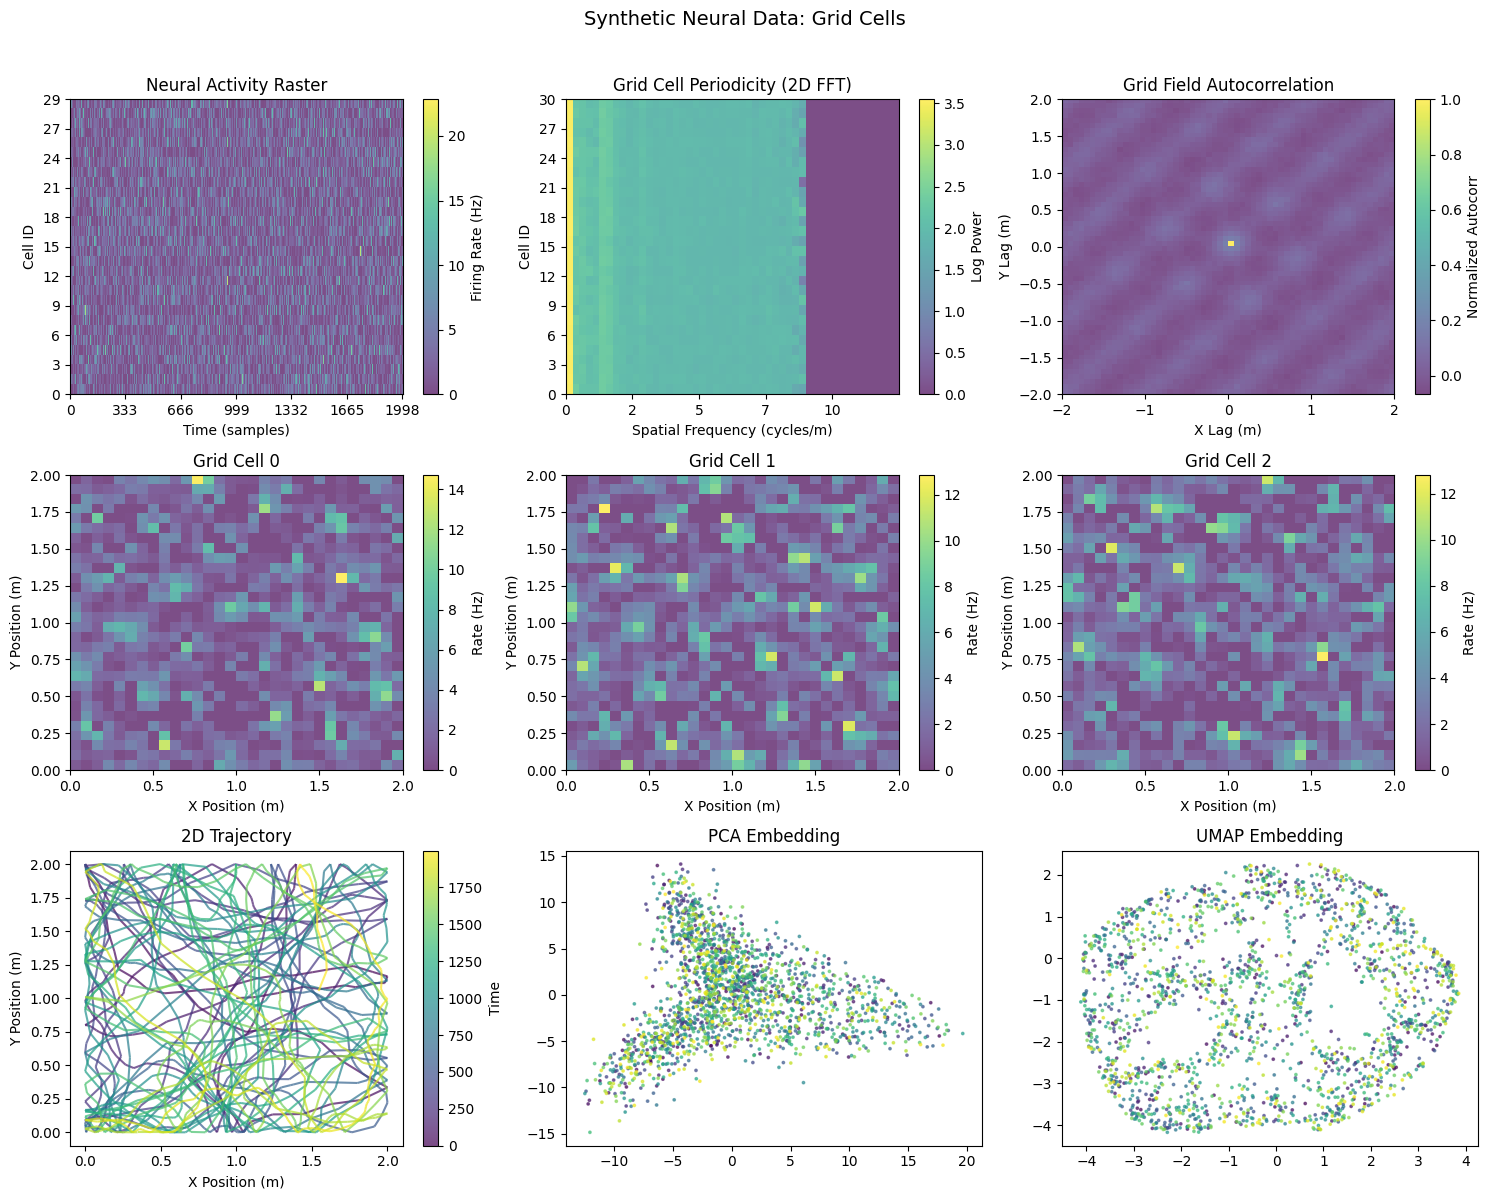

In [43]:
# Generate 2D grid cells
grid_2d, grid_meta_2d = generate_grid_cells(
    n_cells=30,
    n_samples=2000,
    arena_size=(2.0, 2.0),
    grid_spacing=0.35,
    grid_orientation=15.0,  # 15 degree rotation
    peak_rate=10.0,
    noise_level=1,
    seed=SEED,
)

print(f"2D Grid Cells:")
print(f"  Activity shape: {grid_2d.shape}")
print(f"  Dimensionality: {grid_meta_2d['n_dims']}D")
print(f"  Grid spacing: {grid_meta_2d['grid_spacing']}m")
print(f"  Grid orientation: {grid_meta_2d['grid_orientation']}°")

In [22]:
# Reload modules to get the autocorrelation fix
import importlib
import neural_analysis.plotting.synthetic_plots

importlib.reload(neural_analysis.plotting.synthetic_plots)

<module 'neural_analysis.plotting.synthetic_plots' from '/mnt/c/Users/mauls/Documents/Code/neural-analysis/src/neural_analysis/plotting/synthetic_plots.py'>

### 3D Grid Cells

Hexagonal/tetrahedral grid pattern in 3D volumetric space using FCC-like structure with 4 tetrahedral axes for biological realism.

/mnt/c/Users/mauls/Documents/Code/neural-analysis/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


3D Grid Cells:
  Activity shape: (2000, 20)
  Dimensionality: 3D
  Grid spacing: 0.8m


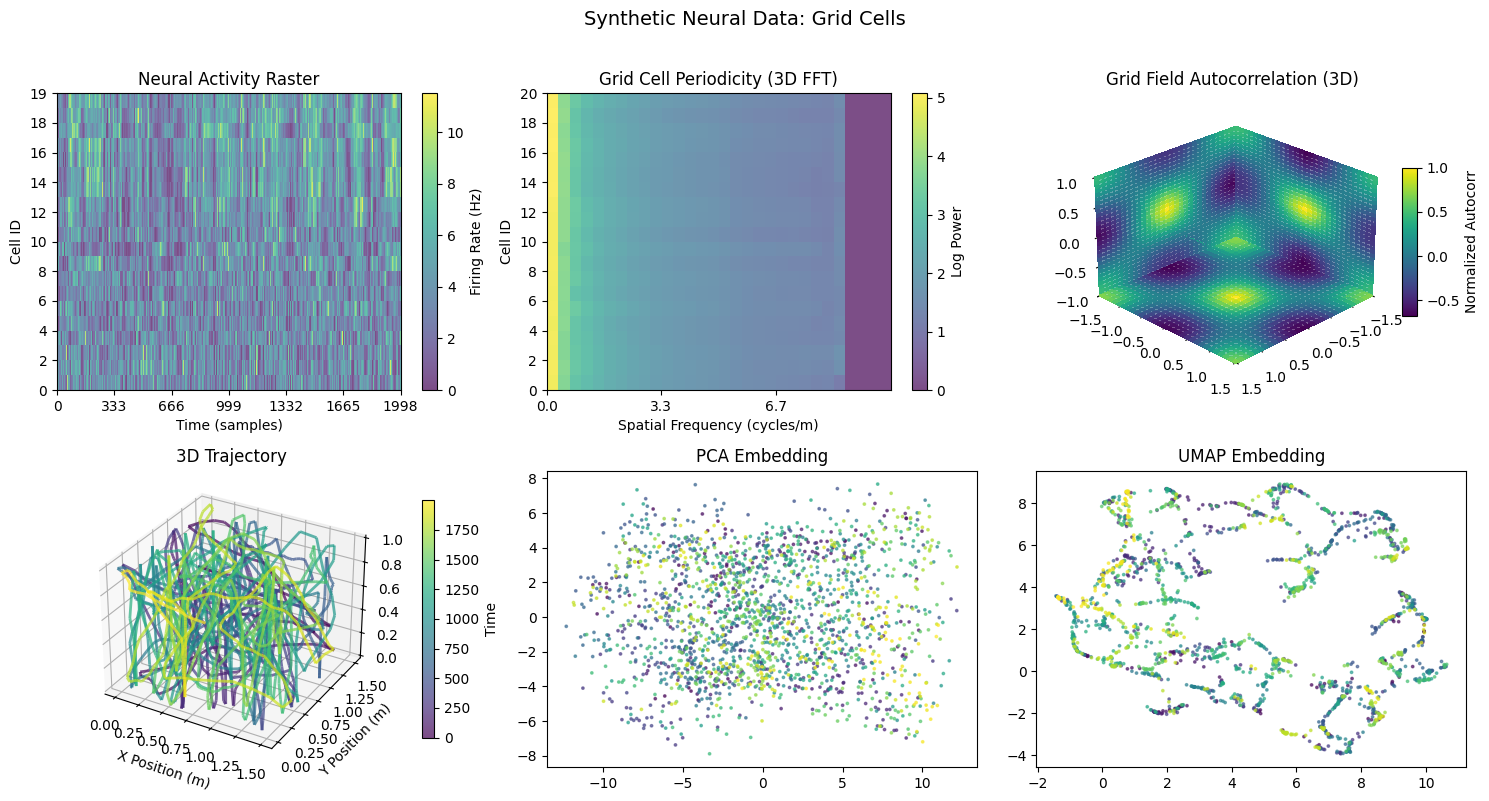

In [41]:
# Generate 3D grid cells
grid_3d, grid_meta_3d = generate_grid_cells(
    n_cells=20,
    n_samples=2000,
    arena_size=(1.5, 1.5, 1.0),
    grid_spacing=0.3,
    peak_rate=10.0,
    noise_level=0.05,
    seed=SEED,
)

print(f"3D Grid Cells:")
print(f"  Activity shape: {grid_3d.shape}")
print(f"  Dimensionality: {grid_meta_3d['n_dims']}D")
print(f"  Grid spacing: {grid_meta_3d['grid_spacing']}m")

## Part 3: Head Direction Cells

Head direction cells fire when the animal's head points in a specific direction.

/mnt/c/Users/mauls/Documents/Code/neural-analysis/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Head Direction Cells:
  Activity shape: (1000, 40)
  Head direction shape: (1000,)
  Tuning width: 30.0°


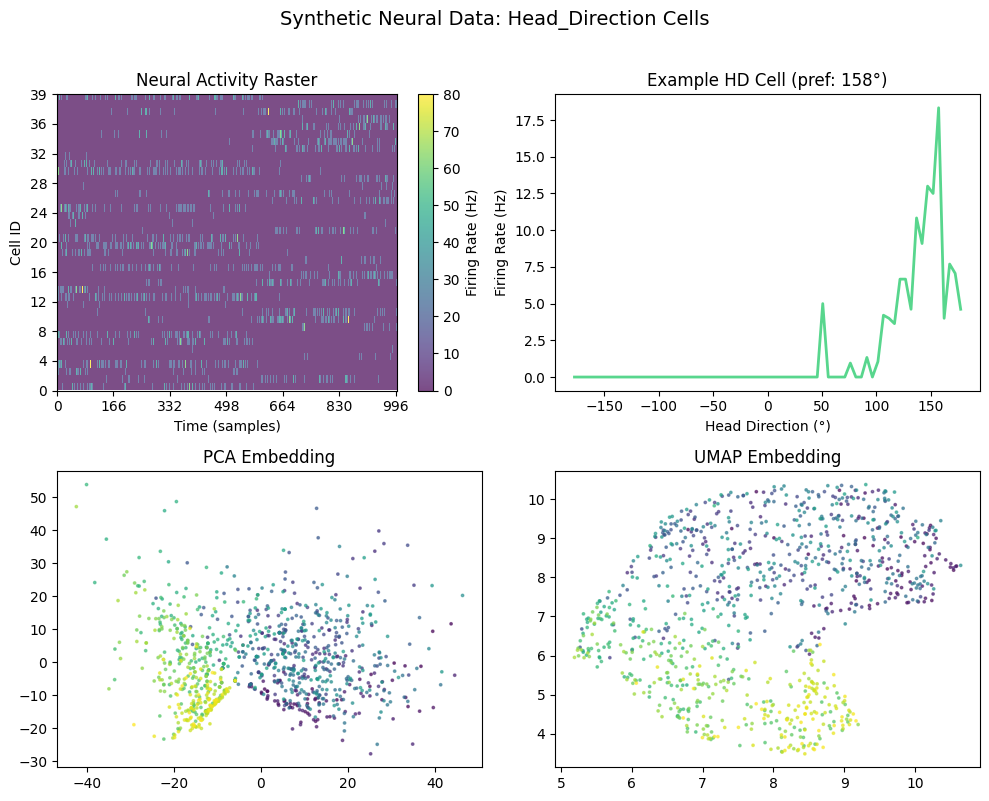

In [16]:
# Generate head direction cells
hd_activity, hd_meta = generate_head_direction_cells(
    n_cells=40,
    n_samples=1000,
    tuning_width=np.pi / 6,  # 30 degrees
    peak_rate=10.0,
    noise_level=0.05,
    seed=SEED,
    plot=True,  # Use integrated plotting
)

print(f"Head Direction Cells:")
print(f"  Activity shape: {hd_activity.shape}")
print(f"  Head direction shape: {hd_meta['head_directions'].shape}")  # Fixed: plural
print(f"  Tuning width: {np.degrees(hd_meta['tuning_width']):.1f}°")

## Part 4: Manifold Mappings

Now let's map the population activity to their true underlying manifolds:
- **Ring (S¹)** for place cells (1D) and head direction cells
- **Torus (T²)** for grid cells (2D)

### Map Place Cells to Ring (1D → 2D Circle)

Ring mapping:
  Input positions: (500, 1)
  Ring coordinates: (500, 2)
✅ The 1D position perfectly maps to a ring (circle)!


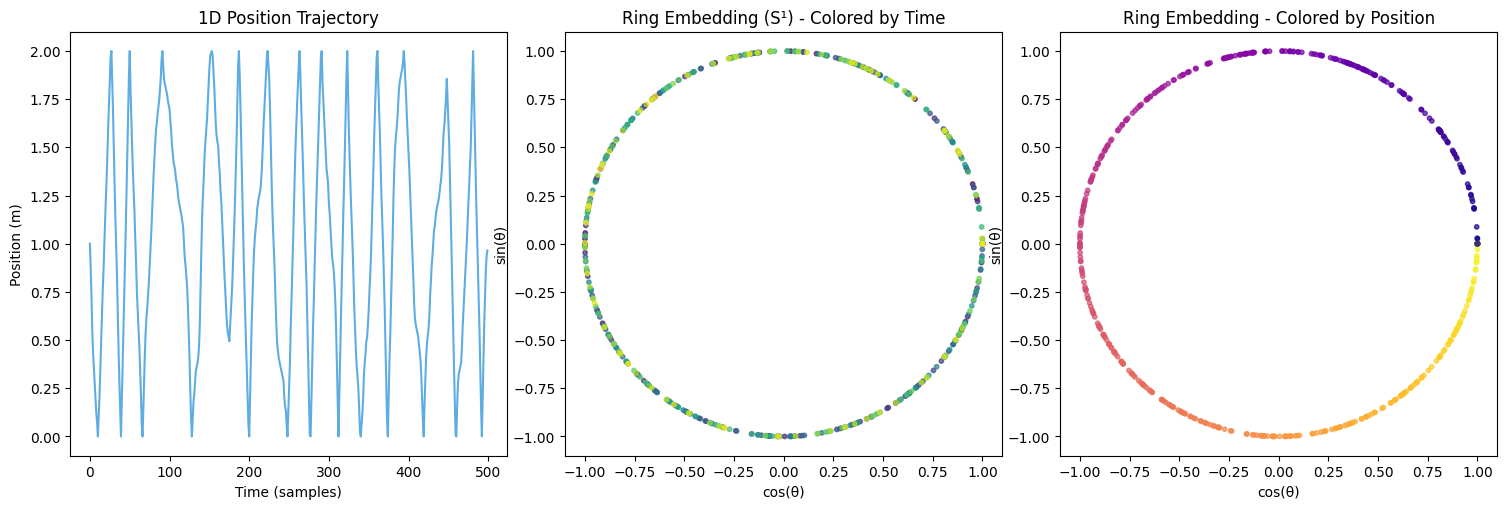

In [17]:
# Map 1D place cells to ring
ring_coords = map_to_ring(activity_1d, meta_1d["positions"], plot=True)

print(f"Ring mapping:")
print(f"  Input positions: {meta_1d['positions'].shape}")
print(f"  Ring coordinates: {ring_coords.shape}")
print("✅ The 1D position perfectly maps to a ring (circle)!")

### Map Head Direction Cells to Ring

HD Ring mapping:
  Input angles: (1000,)
  Ring coordinates: (1000, 2)
✅ Head direction perfectly maps to a ring (circle)!


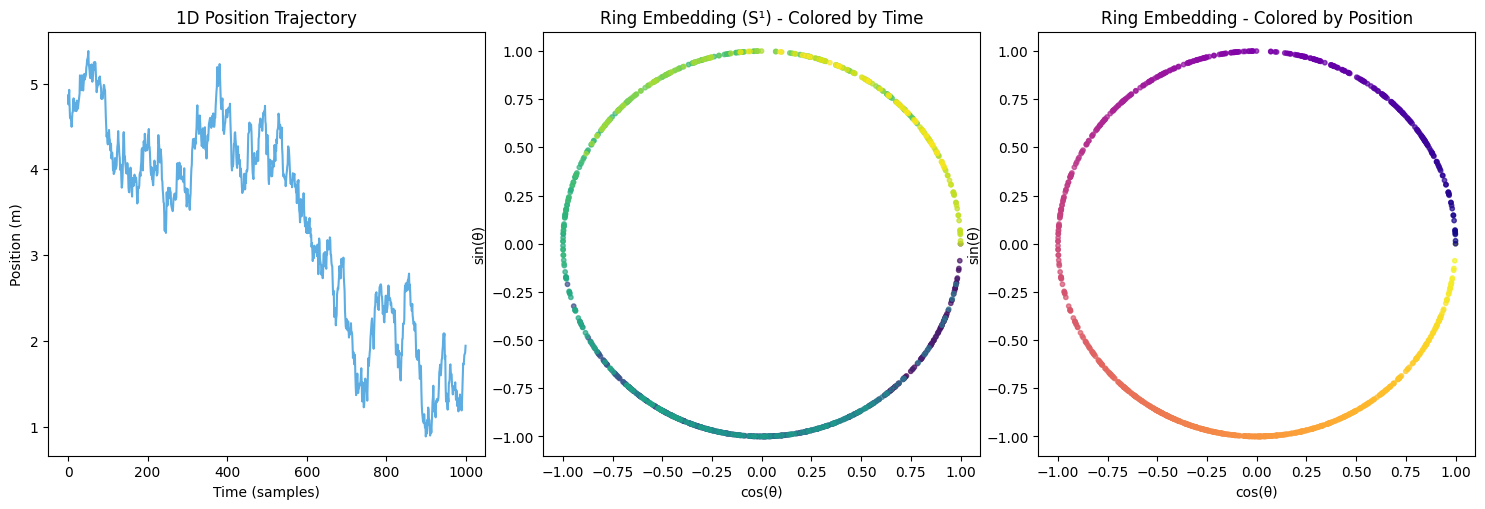

In [18]:
# Map head direction to ring
hd_ring = map_to_ring(hd_activity, hd_meta["head_directions"], plot=True)

print(f"HD Ring mapping:")
print(f"  Input angles: {hd_meta['head_directions'].shape}")
print(f"  Ring coordinates: {hd_ring.shape}")
print("✅ Head direction perfectly maps to a ring (circle)!")

### Map Grid Cells to Torus (2D → 3D Torus)

Torus mapping:
  Input positions: (2000, 2)
  Torus coordinates: (2000, 3)
✅ The 2D periodic space perfectly maps to a torus!


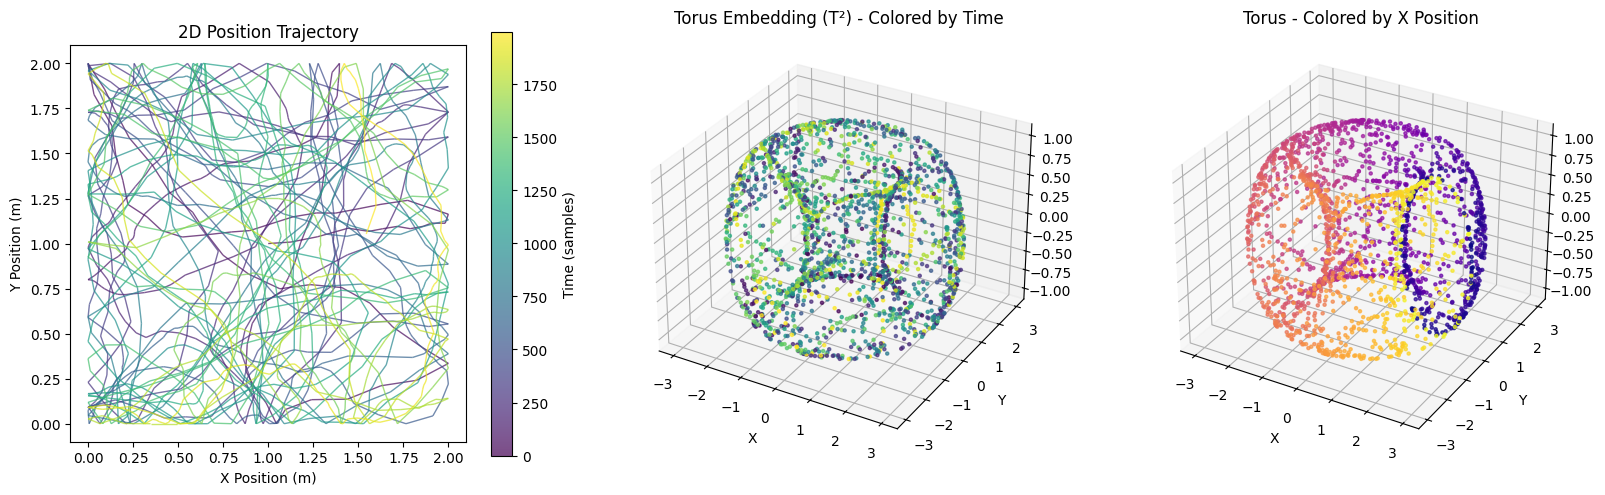

In [19]:
# Map 2D grid cells to torus
torus_coords = map_to_torus(
    grid_2d, grid_meta_2d["positions"], major_radius=2.0, minor_radius=1.0, plot=True
)

print(f"Torus mapping:")
print(f"  Input positions: {grid_meta_2d['positions'].shape}")
print(f"  Torus coordinates: {torus_coords.shape}")
print("✅ The 2D periodic space perfectly maps to a torus!")

## Part 5: Mixed Neural Populations

Create realistic datasets with mixtures of different cell types using flexible configuration.

/mnt/c/Users/mauls/Documents/Code/neural-analysis/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



✅ Mixed population generated with custom configuration!


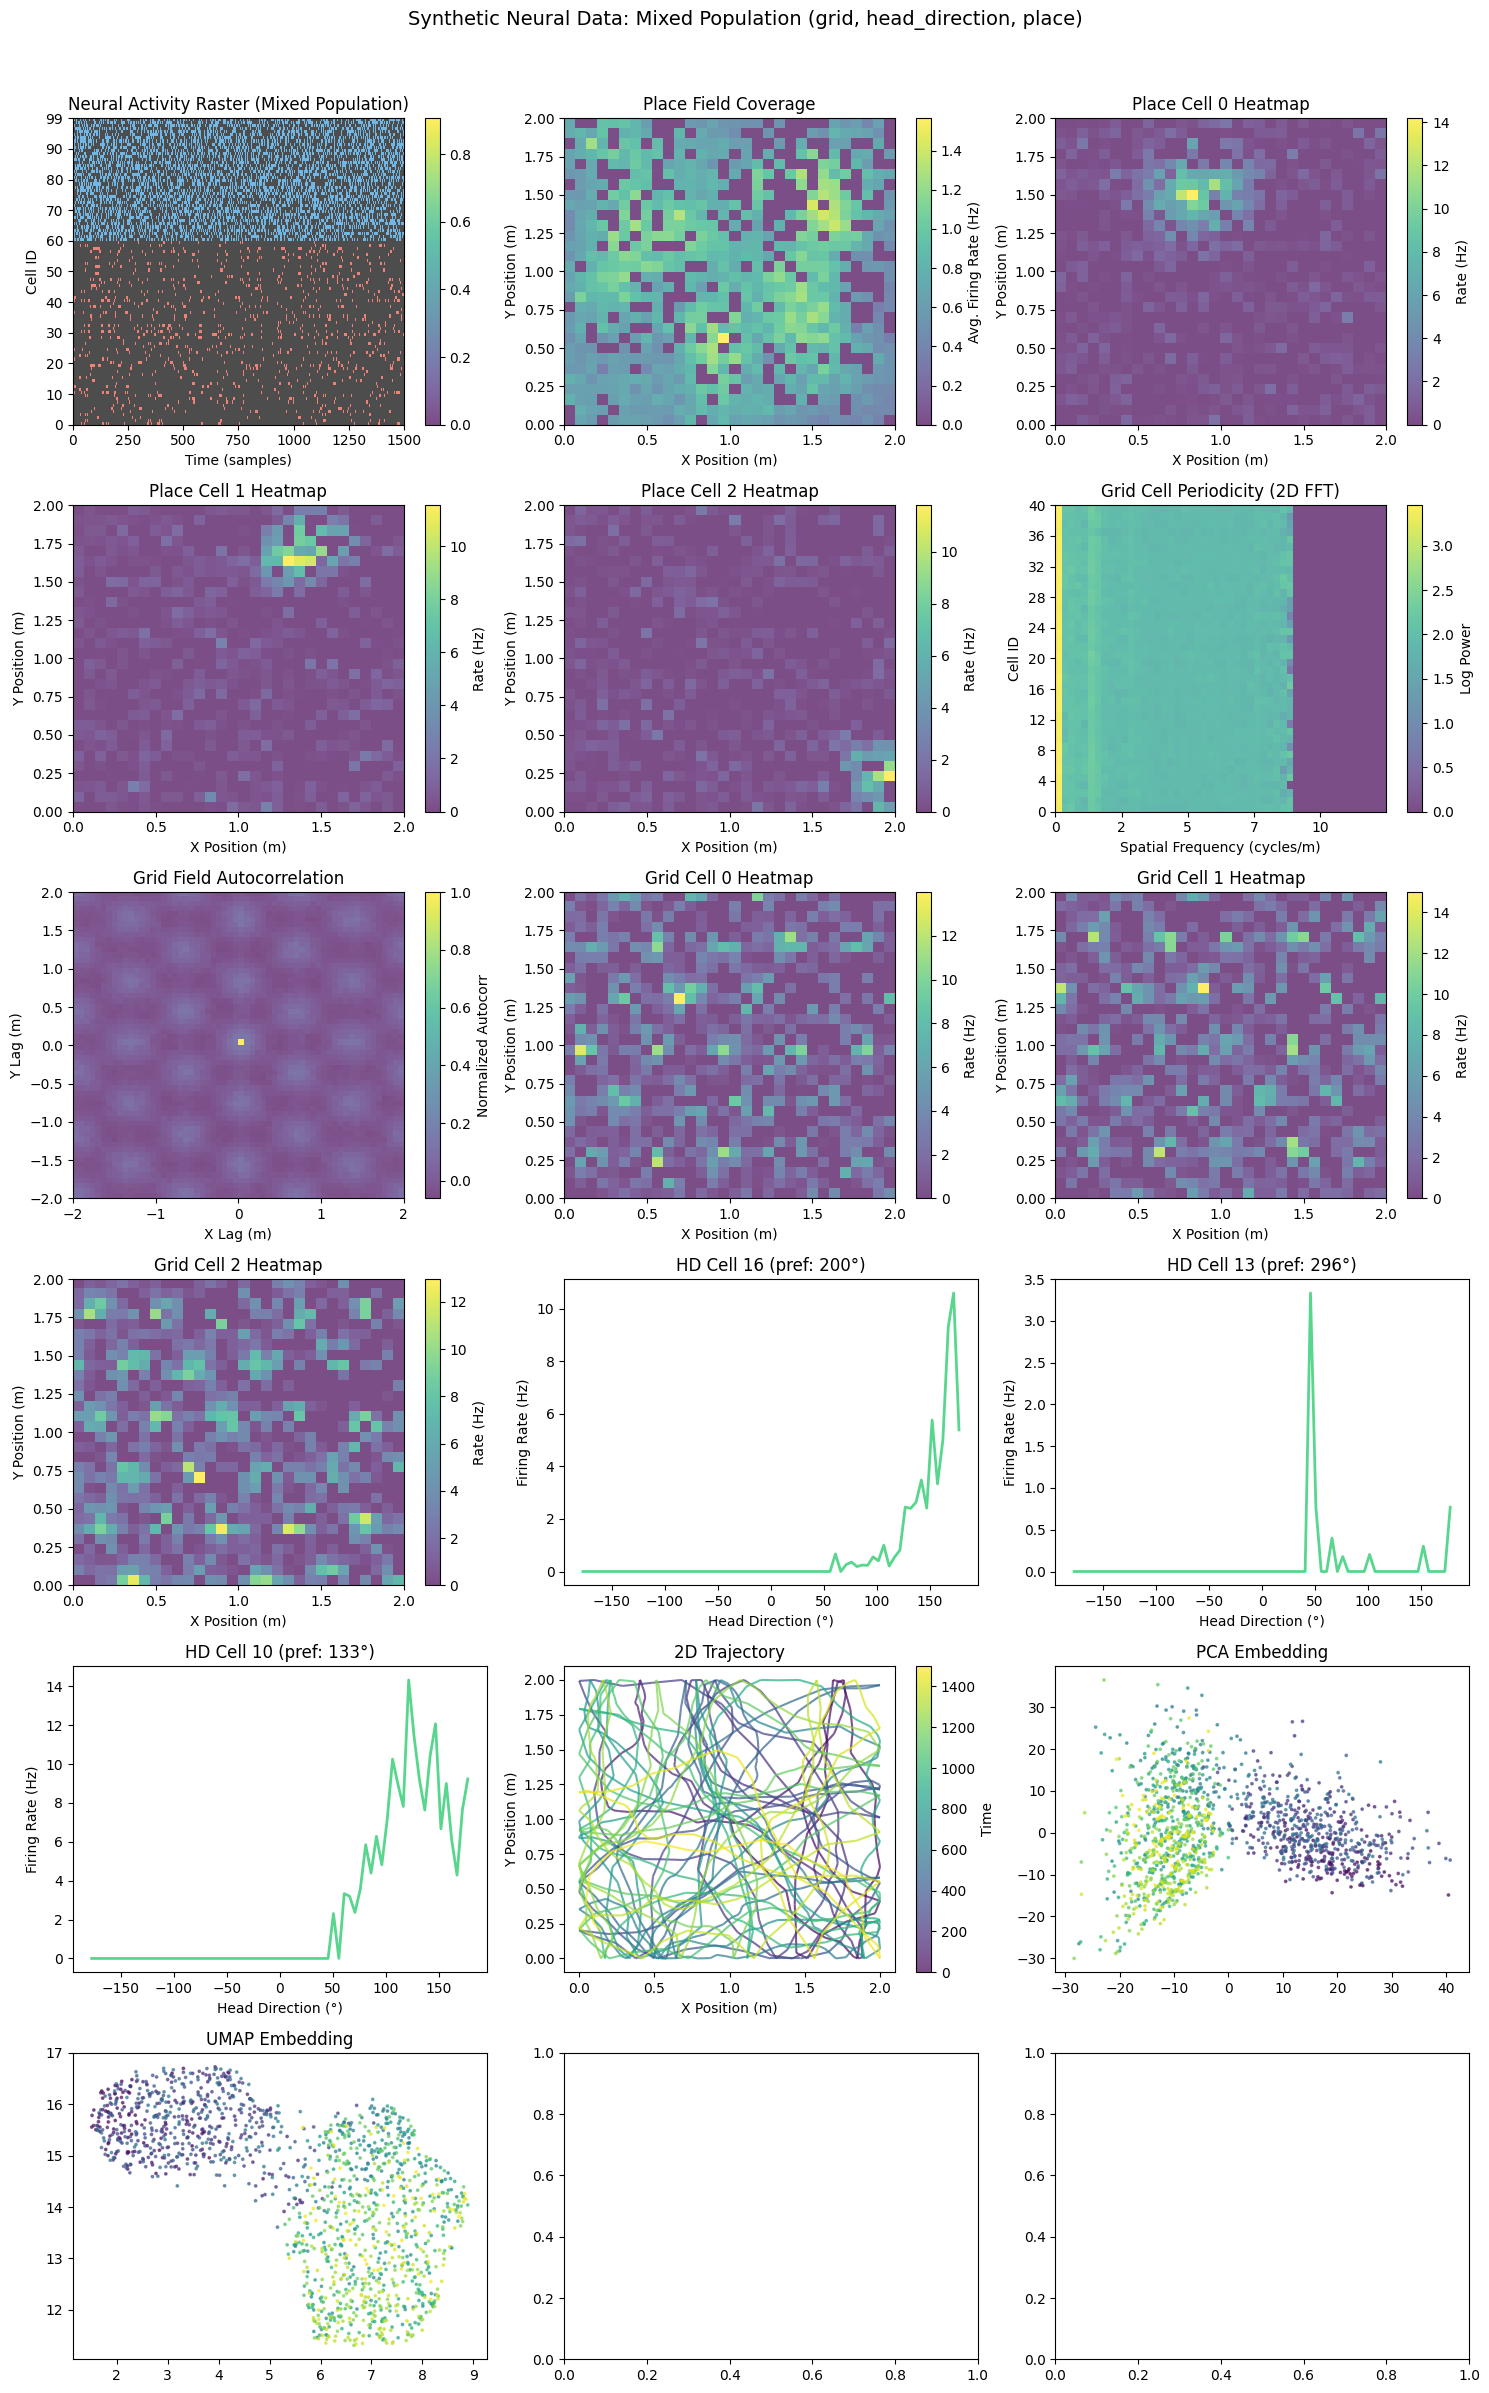

In [36]:
# Define cell configuration
cell_config = {
    "place": {"n_cells": 60, "field_size": 0.18, "noise_level": 0.08},
    "grid": {"n_cells": 40, "grid_spacing": 0.35, "noise_level": 0.05},
    "head_direction": {"n_cells": 30, "tuning_width": np.pi / 5, "noise_level": 0.1},
}

# Generate mixed population
mixed_activity, mixed_meta = generate_mixed_population_flexible(
    cell_config=cell_config, n_samples=1500, arena_size=(2.0, 2.0), seed=SEED
)
print("\n✅ Mixed population generated with custom configuration!")

/mnt/c/Users/mauls/Documents/Code/neural-analysis/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



✅ Full mixed population generated (including random cells)!


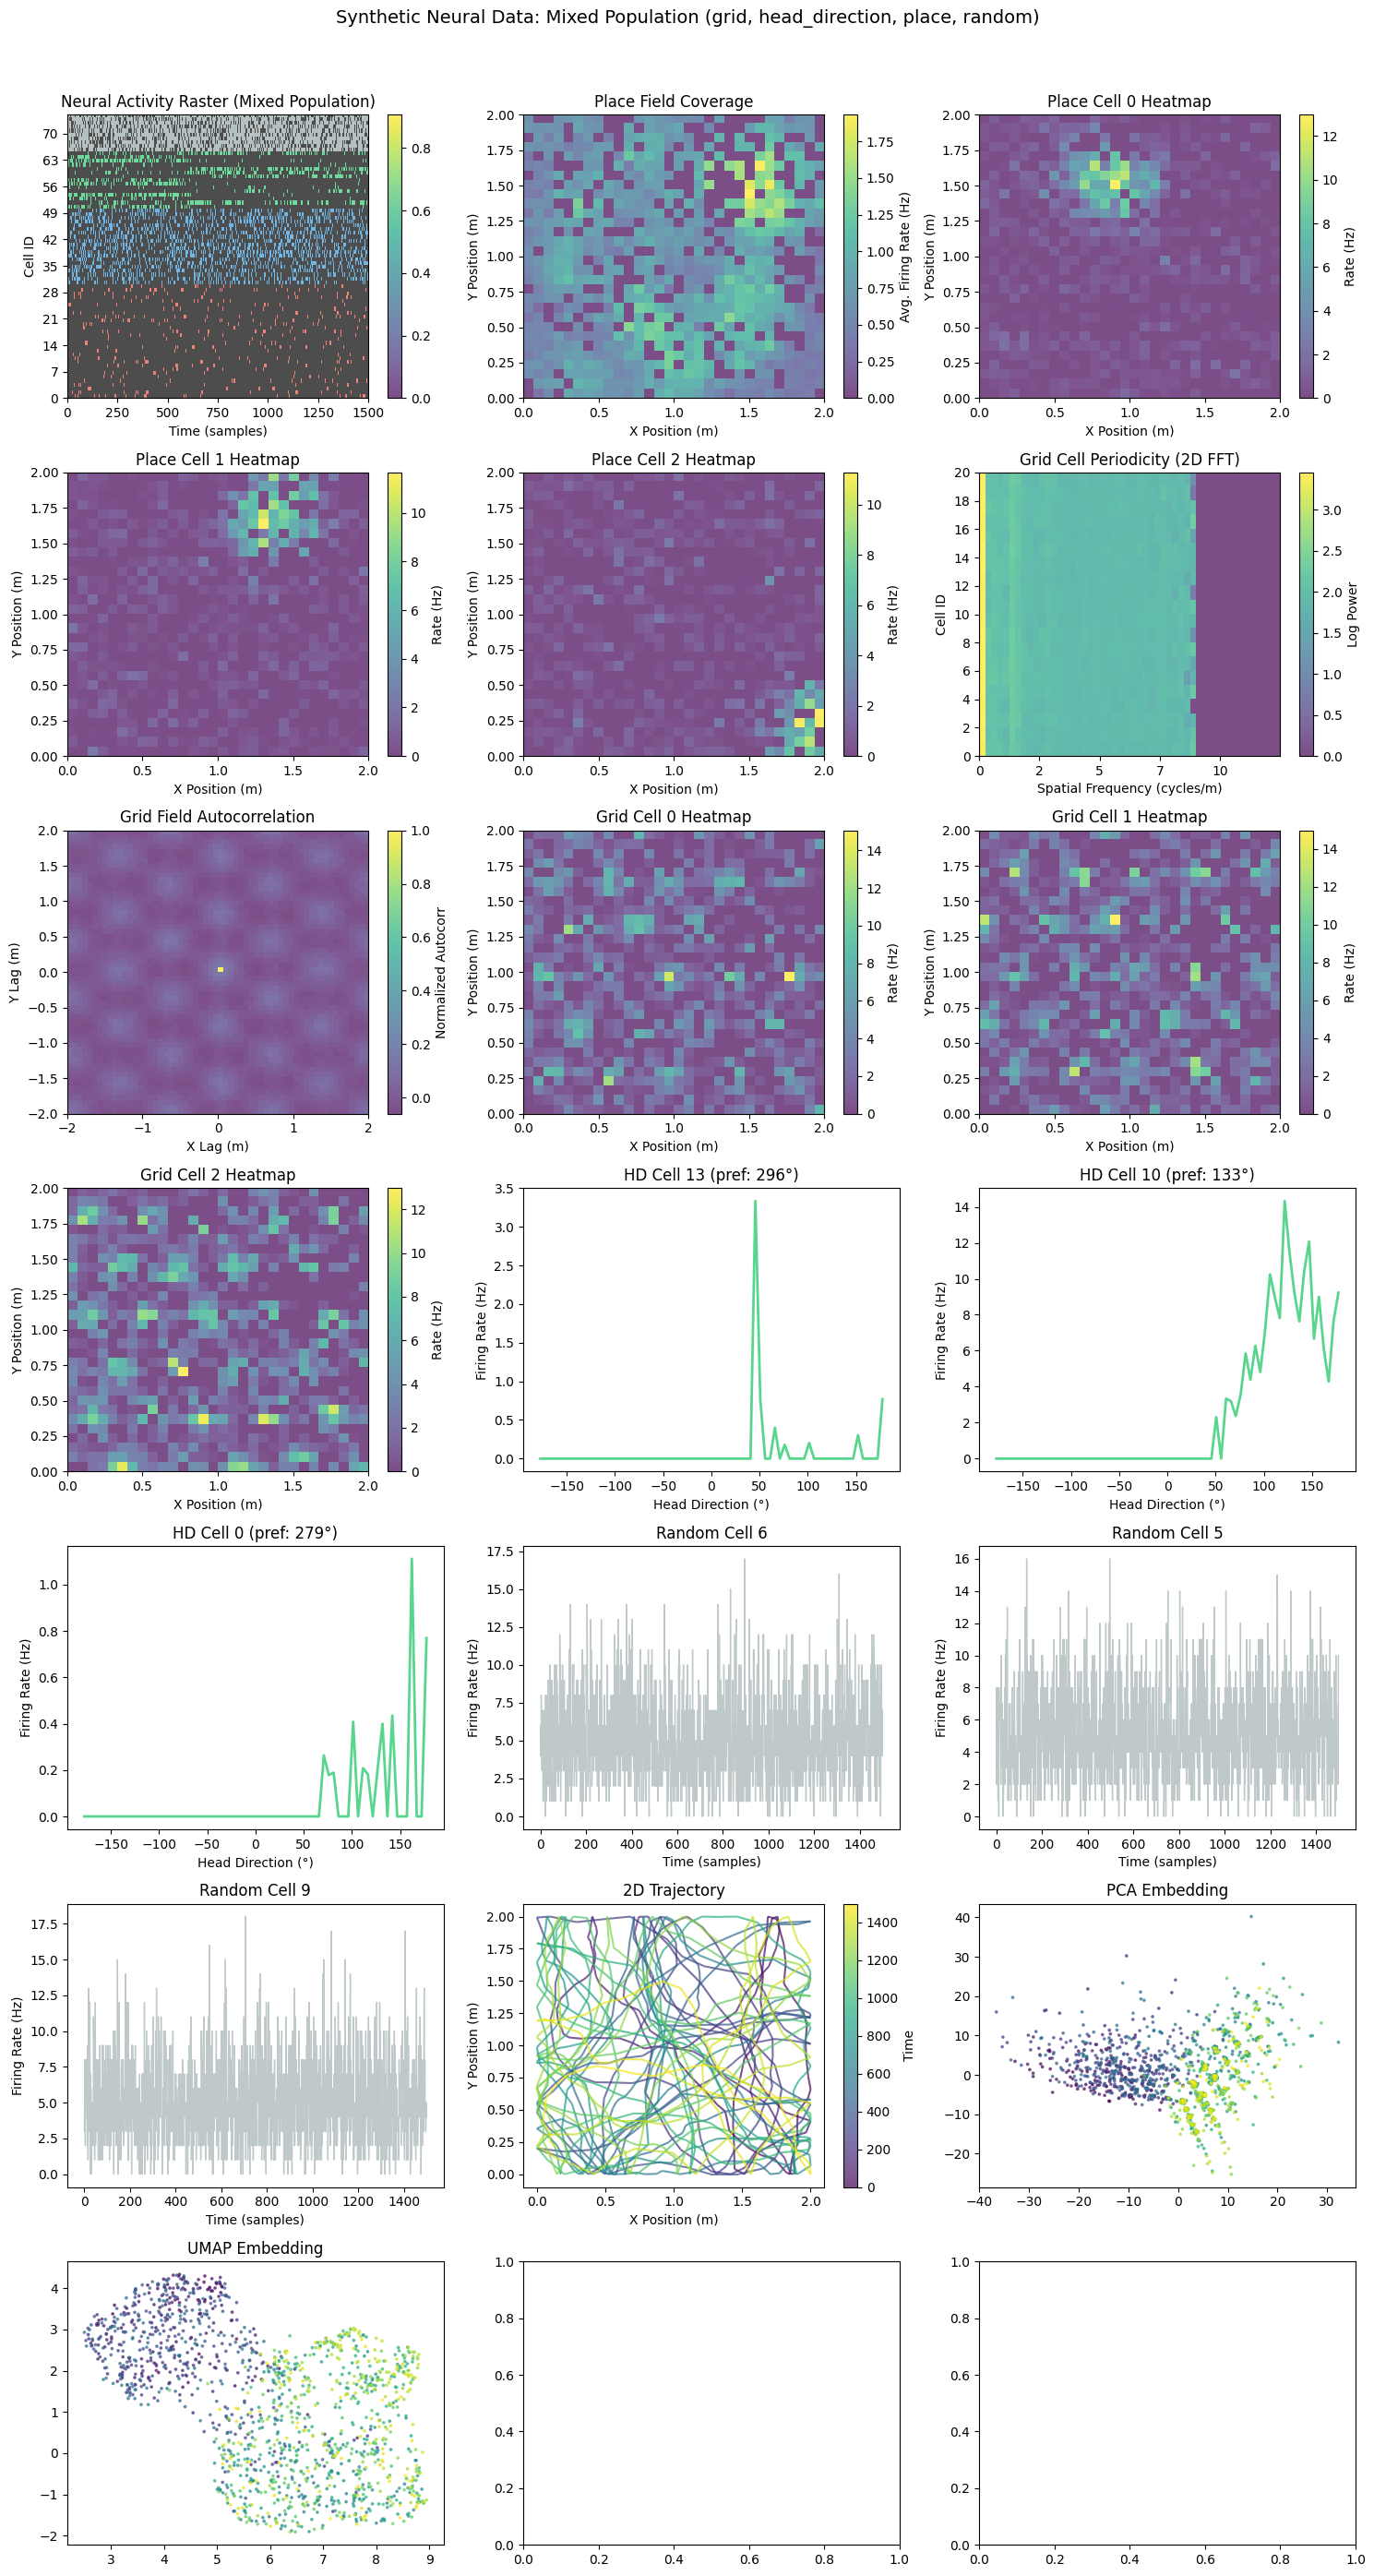

In [39]:
# Test with random cells added to the configuration
cell_config_with_random = {
    "place": {"n_cells": 30, "field_size": 0.18, "noise_level": 0.08},
    "grid": {"n_cells": 20, "grid_spacing": 0.35, "noise_level": 0.05},
    "head_direction": {"n_cells": 15, "tuning_width": np.pi / 5, "noise_level": 0.1},
    "random": {
        "n_cells": 10,
        "baseline_rate": 5.0,
        "variability": 2.0,
        "temporal_smoothness": 0.2,
    },
}

# Generate mixed population with random cells
mixed_activity_full, mixed_meta_full = generate_mixed_population_flexible(
    cell_config=cell_config_with_random,
    n_samples=1500,
    arena_size=(2.0, 2.0),
    seed=SEED,
)
print("\n✅ Full mixed population generated (including random cells)!")

## Part 6: Embedding Quality - Perfect vs. Noisy vs. Mixed

Compare how embeddings degrade from perfect → noisy → mixed populations.

### Perfect Place Cell Embeddings

First, generate perfect (noise-free) place cells and embed them.

/mnt/c/Users/mauls/Documents/Code/neural-analysis/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✅ Perfect place cells produce clean embeddings!


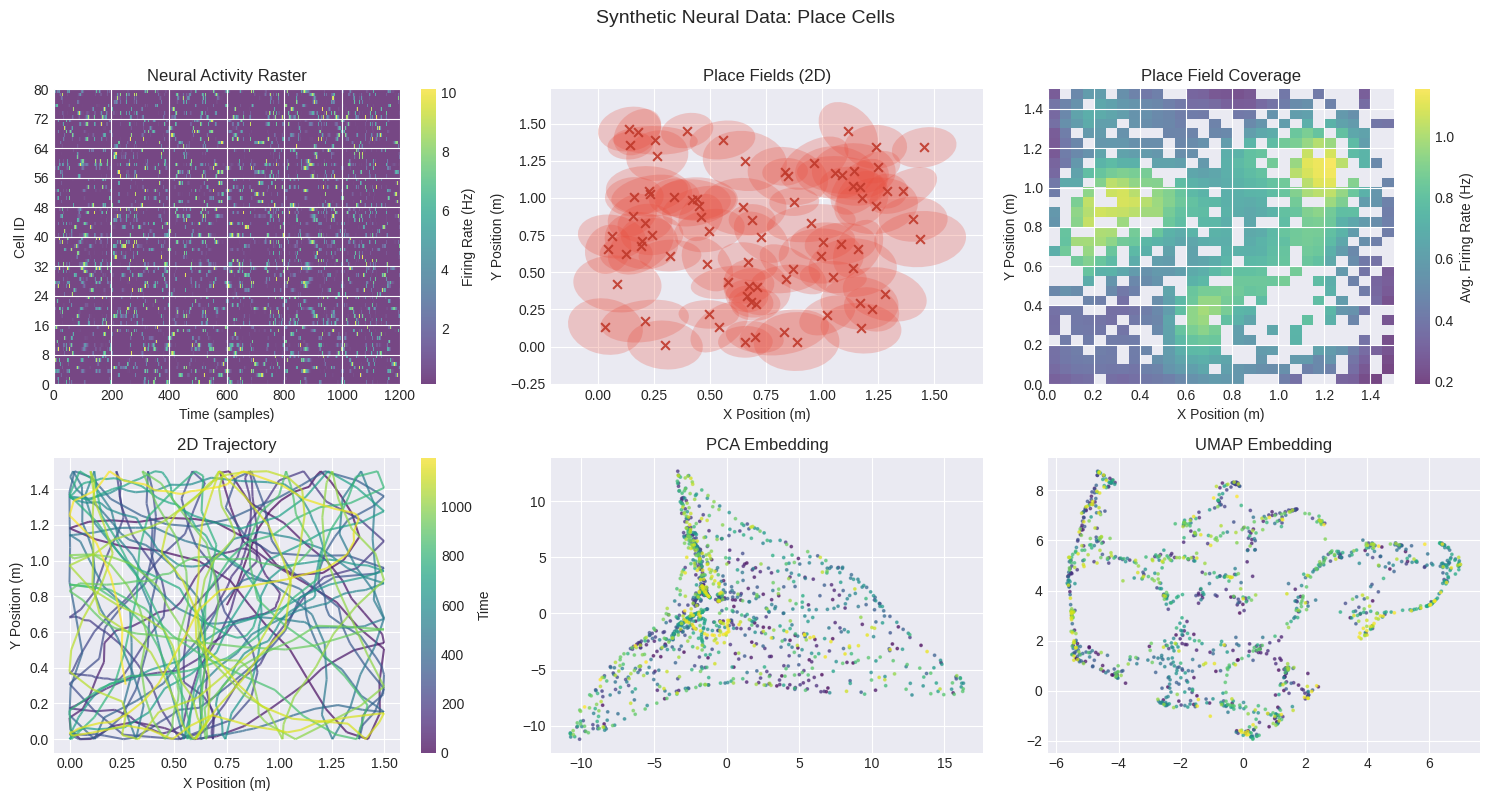

In [ ]:
# Generate perfect (noise-free) place cells for 2D
perfect_activity, perfect_meta = generate_place_cells(
    n_cells=80,
    n_samples=1200,
    arena_size=(1.5, 1.5),
    field_size=0.15,
    noise_level=0.0,  # No noise!
    seed=SEED,
)
print("✅ Perfect place cells produce clean embeddings!")

### Noisy Place Cell Embeddings

Now add varying levels of noise and see how embeddings degrade.

In [3]:
# Generate place cells with varying noise levels
noise_levels = [0.0, 0.1, 0.3, 0.5]
noisy_embeddings = []
noisy_activities = []

for noise in noise_levels:
    activity, meta = generate_place_cells(
        n_cells=80,
        n_samples=1200,
        arena_size=(1.5, 1.5),
        field_size=0.15,
        noise_level=noise,
        positions=perfect_meta["positions"],  # Use same trajectory!
        seed=SEED,
        plot=False,
    )

    # Embed with UMAP
    umap = UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=SEED)
    embedding = umap.fit_transform(activity)

    noisy_embeddings.append(embedding)
    noisy_activities.append(activity)

# Visualize
fig = plt.figure(figsize=(16, 8))
gs = GridSpec(2, 4, hspace=0.3, wspace=0.3)

for idx, (noise, embedding, activity) in enumerate(
    zip(noise_levels, noisy_embeddings, noisy_activities)
):
    # Raster plot
    ax1 = fig.add_subplot(gs[0, idx])
    im = ax1.imshow(activity.T, aspect="auto", cmap="hot", interpolation="nearest")
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Cell ID" if idx == 0 else "")
    ax1.set_title(f"Noise = {noise}")

    # UMAP embedding
    ax2 = fig.add_subplot(gs[1, idx])
    scatter = ax2.scatter(
        embedding[:, 0],
        embedding[:, 1],
        c=np.arange(len(embedding)),
        cmap="viridis",
        s=5,
        alpha=0.7,
    )
    ax2.set_xlabel("UMAP 1")
    ax2.set_ylabel("UMAP 2" if idx == 0 else "")
    ax2.set_title(f"Embedding (noise={noise})")
    ax2.set_aspect("equal")

plt.suptitle("Place Cell Embeddings: Impact of Noise", fontsize=14, y=0.995)
plt.tight_layout()
plt.show()

print("✅ Embedding quality degrades with increasing noise!")

NameError: name 'perfect_meta' is not defined

### Mixed Population Embeddings

Embedding mixed populations is more challenging than pure populations.

In [ ]:
# Embed the mixed population
print("Embedding mixed population...")
umap_mixed = UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=SEED)
mixed_embedding = umap_mixed.fit_transform(mixed_activity)

# Also embed just place cells from mixed population for comparison
place_indices = mixed_meta["cell_indices"]["place"]
place_only_activity = mixed_activity[:, place_indices]
umap_place_only = UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=SEED)
place_only_embedding = umap_place_only.fit_transform(place_only_activity)

# Visualize comparison
fig = plt.figure(figsize=(16, 10))
gs = GridSpec(3, 3, height_ratios=[1, 2, 2], hspace=0.35, wspace=0.3)

# Trajectory
ax0 = fig.add_subplot(gs[0, :])
scatter = ax0.scatter(
    mixed_meta["positions"][:, 0],
    mixed_meta["positions"][:, 1],
    c=np.arange(len(mixed_meta["positions"])),
    cmap="viridis",
    s=5,
    alpha=0.7,
)
ax0.set_xlabel("X Position (m)")
ax0.set_ylabel("Y Position (m)")
ax0.set_title("True 2D Trajectory (Shared for All Cell Types)")
ax0.set_aspect("equal")
plt.colorbar(scatter, ax=ax0, label="Time", orientation="horizontal")

# Pure place cells (from earlier)
ax1 = fig.add_subplot(gs[1, 0])
im = ax1.imshow(perfect_activity.T, aspect="auto", cmap="hot", interpolation="nearest")
ax1.set_xlabel("Time")
ax1.set_ylabel("Cell ID")
ax1.set_title("Pure Place Cells")
plt.colorbar(im, ax=ax1, label="Rate")

ax2 = fig.add_subplot(gs[2, 0])
scatter = ax2.scatter(
    perfect_embedding[:, 0],
    perfect_embedding[:, 1],
    c=np.arange(len(perfect_embedding)),
    cmap="viridis",
    s=5,
    alpha=0.7,
)
ax2.set_xlabel("UMAP 1")
ax2.set_ylabel("UMAP 2")
ax2.set_title("Embedding: Pure Place Cells")
ax2.set_aspect("equal")

# Place cells only from mixed
ax3 = fig.add_subplot(gs[1, 1])
im = ax3.imshow(
    place_only_activity.T, aspect="auto", cmap="hot", interpolation="nearest"
)
ax3.set_xlabel("Time")
ax3.set_ylabel("Cell ID")
ax3.set_title(f"Place Cells from Mixed Pop")
plt.colorbar(im, ax=ax3, label="Rate")

ax4 = fig.add_subplot(gs[2, 1])
scatter = ax4.scatter(
    place_only_embedding[:, 0],
    place_only_embedding[:, 1],
    c=np.arange(len(place_only_embedding)),
    cmap="viridis",
    s=5,
    alpha=0.7,
)
ax4.set_xlabel("UMAP 1")
ax4.set_ylabel("UMAP 2")
ax4.set_title("Embedding: Place Cells Only")
ax4.set_aspect("equal")

# Full mixed population
ax5 = fig.add_subplot(gs[1, 2])
im = ax5.imshow(mixed_activity.T, aspect="auto", cmap="hot", interpolation="nearest")
ax5.set_xlabel("Time")
ax5.set_ylabel("Cell ID")
ax5.set_title(f"Mixed Population (All Types)")
# Add bars for cell types
for cell_type, indices in mixed_meta["cell_indices"].items():
    color = {"place": "cyan", "grid": "yellow", "head_direction": "magenta"}[cell_type]
    ax5.axhspan(indices[0] - 0.5, indices[-1] + 0.5, alpha=0.15, color=color, zorder=-1)
plt.colorbar(im, ax=ax5, label="Rate")

ax6 = fig.add_subplot(gs[2, 2])
scatter = ax6.scatter(
    mixed_embedding[:, 0],
    mixed_embedding[:, 1],
    c=np.arange(len(mixed_embedding)),
    cmap="viridis",
    s=5,
    alpha=0.7,
)
ax6.set_xlabel("UMAP 1")
ax6.set_ylabel("UMAP 2")
ax6.set_title("Embedding: Mixed Population")
ax6.set_aspect("equal")

plt.suptitle("Embedding Quality: Pure → Place Only → Mixed Population", fontsize=14)
plt.tight_layout()
plt.show()

print("✅ Mixed populations produce more complex embeddings!")

Embedding mixed population...


NameError: name 'mixed_activity' is not defined

## Part 7: sklearn Manifold Datasets

Classic manifold datasets for benchmarking dimensionality reduction algorithms.

In [ ]:
# Generate all sklearn manifold datasets
print("Generating sklearn manifold datasets...")

# Swiss roll
swiss_roll, swiss_colors = generate_swiss_roll(n_samples=1500, noise=0.1, seed=SEED)

# S-curve
s_curve, s_colors = generate_s_curve(n_samples=1500, noise=0.1, seed=SEED)

# Blobs
blobs, blob_labels = generate_data(
    "blobs", n_samples=800, n_features=3, n_classes=4, noise=0.1, seed=SEED
)

# Moons
moons, moon_labels = generate_data("moons", n_samples=800, noise=0.1, seed=SEED)

# Circles
circles, circle_labels = generate_data(
    "circles", n_samples=800, noise=0.05, factor=0.5, seed=SEED
)

print("✅ All sklearn datasets generated!")

# Visualize
fig = plt.figure(figsize=(16, 10))
gs = GridSpec(2, 3, hspace=0.3, wspace=0.3)

# Swiss Roll
ax1 = fig.add_subplot(gs[0, 0], projection="3d")
scatter = ax1.scatter(
    swiss_roll[:, 0],
    swiss_roll[:, 1],
    swiss_roll[:, 2],
    c=swiss_colors,
    cmap="viridis",
    s=5,
    alpha=0.7,
)
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.set_zlabel("Z")
ax1.set_title("Swiss Roll")
plt.colorbar(scatter, ax=ax1, shrink=0.5, label="Color")

# S-Curve
ax2 = fig.add_subplot(gs[0, 1], projection="3d")
scatter = ax2.scatter(
    s_curve[:, 0],
    s_curve[:, 1],
    s_curve[:, 2],
    c=s_colors,
    cmap="plasma",
    s=5,
    alpha=0.7,
)
ax2.set_xlabel("X")
ax2.set_ylabel("Y")
ax2.set_zlabel("Z")
ax2.set_title("S-Curve")
plt.colorbar(scatter, ax=ax2, shrink=0.5, label="Color")

# Blobs
ax3 = fig.add_subplot(gs[0, 2], projection="3d")
scatter = ax3.scatter(
    blobs[:, 0], blobs[:, 1], blobs[:, 2], c=blob_labels, cmap="tab10", s=5, alpha=0.7
)
ax3.set_xlabel("X")
ax3.set_ylabel("Y")
ax3.set_zlabel("Z")
ax3.set_title("Blobs (4 clusters)")
plt.colorbar(scatter, ax=ax3, shrink=0.5, label="Cluster")

# Moons
ax4 = fig.add_subplot(gs[1, 0])
scatter = ax4.scatter(
    moons[:, 0], moons[:, 1], c=moon_labels, cmap="coolwarm", s=10, alpha=0.7
)
ax4.set_xlabel("X")
ax4.set_ylabel("Y")
ax4.set_title("Moons")
ax4.set_aspect("equal")
plt.colorbar(scatter, ax=ax4, label="Class")

# Circles
ax5 = fig.add_subplot(gs[1, 1])
scatter = ax5.scatter(
    circles[:, 0], circles[:, 1], c=circle_labels, cmap="coolwarm", s=10, alpha=0.7
)
ax5.set_xlabel("X")
ax5.set_ylabel("Y")
ax5.set_title("Circles")
ax5.set_aspect("equal")
plt.colorbar(scatter, ax=ax5, label="Class")

# Empty subplot for symmetry
ax6 = fig.add_subplot(gs[1, 2])
ax6.text(
    0.5,
    0.5,
    "sklearn Manifolds\n\nUseful for testing:\n• Dimensionality reduction\n• Clustering algorithms\n• Manifold learning",
    ha="center",
    va="center",
    fontsize=12,
    transform=ax6.transAxes,
)
ax6.axis("off")

plt.suptitle("sklearn Manifold Datasets", fontsize=14)
plt.tight_layout()
plt.show()

### Apply Dimensionality Reduction to sklearn Datasets

Compare how different methods (PCA, Isomap, UMAP) recover manifold structure.

In [ ]:
# Apply dimensionality reduction methods to Swiss Roll
print("Applying dimensionality reduction to Swiss Roll...")

# PCA
pca = PCA(n_components=2, random_state=SEED)
swiss_pca = pca.fit_transform(swiss_roll)

# Isomap
isomap = Isomap(n_components=2, n_neighbors=10)
swiss_isomap = isomap.fit_transform(swiss_roll)

# UMAP
umap = UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=SEED)
swiss_umap = umap.fit_transform(swiss_roll)

# Visualize
fig = plt.figure(figsize=(16, 5))

# Original 3D
ax1 = fig.add_subplot(141, projection="3d")
scatter = ax1.scatter(
    swiss_roll[:, 0],
    swiss_roll[:, 1],
    swiss_roll[:, 2],
    c=swiss_colors,
    cmap="viridis",
    s=5,
    alpha=0.7,
)
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.set_zlabel("Z")
ax1.set_title("Original Swiss Roll (3D)")
plt.colorbar(scatter, ax=ax1, shrink=0.5, label="True Color")

# PCA
ax2 = fig.add_subplot(142)
scatter = ax2.scatter(
    swiss_pca[:, 0], swiss_pca[:, 1], c=swiss_colors, cmap="viridis", s=10, alpha=0.7
)
ax2.set_xlabel("PC 1")
ax2.set_ylabel("PC 2")
ax2.set_title("PCA (Linear)")
ax2.set_aspect("equal")
plt.colorbar(scatter, ax=ax2, label="True Color")

# Isomap
ax3 = fig.add_subplot(143)
scatter = ax3.scatter(
    swiss_isomap[:, 0],
    swiss_isomap[:, 1],
    c=swiss_colors,
    cmap="viridis",
    s=10,
    alpha=0.7,
)
ax3.set_xlabel("Isomap 1")
ax3.set_ylabel("Isomap 2")
ax3.set_title("Isomap (Geodesic)")
ax3.set_aspect("equal")
plt.colorbar(scatter, ax=ax3, label="True Color")

# UMAP
ax4 = fig.add_subplot(144)
scatter = ax4.scatter(
    swiss_umap[:, 0], swiss_umap[:, 1], c=swiss_colors, cmap="viridis", s=10, alpha=0.7
)
ax4.set_xlabel("UMAP 1")
ax4.set_ylabel("UMAP 2")
ax4.set_title("UMAP (Topological)")
ax4.set_aspect("equal")
plt.colorbar(scatter, ax=ax4, label="True Color")

plt.suptitle("Swiss Roll: Comparing Dimensionality Reduction Methods", fontsize=14)
plt.tight_layout()
plt.show()

print("✅ Isomap and UMAP successfully 'unroll' the Swiss Roll!")

## Summary and Key Takeaways

This notebook demonstrated comprehensive synthetic dataset generation capabilities:

### Neural Data Generators
✅ **Place Cells** in 1D, 2D, and 3D environments with Gaussian firing fields  
✅ **Grid Cells** in 1D, 2D, and 3D with periodic patterns (1D: periodic, 2D: hexagonal, 3D: cubic)  
✅ **Head Direction Cells** with von Mises tuning curves  
✅ **Mixed Populations** with flexible dictionary-based configuration

### Manifold Mappings
✅ **Ring (S¹)** mapping for place cells (1D) and head direction cells  
✅ **Torus (T²)** mapping for grid cells (2D periodic space)  
✅ **Population Vector Decoding** for trajectory tracking on manifolds

### Embedding Quality Analysis
✅ **Perfect Place Cells** → Clean embeddings that recover true structure  
✅ **Noisy Place Cells** → Embeddings degrade gracefully with noise  
✅ **Mixed Populations** → More complex embeddings reflecting heterogeneous cell types

### sklearn Datasets
✅ **Manifolds**: Swiss roll, S-curve, blobs, moons, circles  
✅ **Dimensionality Reduction**: PCA, Isomap, UMAP comparisons  
✅ **Manifold Learning**: Methods that preserve intrinsic geometry

### Key Functions
- `generate_place_cells()`, `generate_grid_cells()`, `generate_head_direction_cells()`
- `generate_mixed_population_flexible()` - dictionary-based configuration
- `map_to_ring()`, `map_to_torus()` - manifold mappings
- `population_vector_decoder()` - decode position from activity
- `generate_data()` - unified interface for all dataset types

### Next Steps
1. Use these datasets to test your neural analysis methods
2. Benchmark dimensionality reduction algorithms
3. Validate decoding approaches with known ground truth
4. Test cell type classification on mixed populations
5. Study how noise affects embedding quality

**All datasets are reproducible with random seeds!** 🎲